In [10]:
import torch # type: ignore

if __name__ == "__main__":
    print(torch.__version__)
    # Setup device agnostic code
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

2.0.1+cu118
Using device: cuda


In [11]:
import torch


class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x


tinymodel = TinyModel()

print('The model:')
print(tinymodel)

print('\n\nJust one layer:')
print(tinymodel.linear2)

print('\n\nModel params:')
for param in tinymodel.parameters():
    print(param)

print('\n\nLayer params:')
for param in tinymodel.linear2.parameters():
    print(param)

The model:
TinyModel(
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


Just one layer:
Linear(in_features=200, out_features=10, bias=True)


Model params:
Parameter containing:
tensor([[-0.0708, -0.0851,  0.0290,  ...,  0.0032, -0.0527,  0.0193],
        [ 0.0232, -0.0486,  0.0378,  ..., -0.0408,  0.0732, -0.0149],
        [ 0.0373,  0.0352, -0.0231,  ...,  0.0403, -0.0399, -0.0527],
        ...,
        [ 0.0759,  0.0617, -0.0757,  ..., -0.0038,  0.0693, -0.0414],
        [-0.0157,  0.0224,  0.0283,  ...,  0.0580, -0.0439,  0.0638],
        [ 0.0731, -0.0434,  0.0294,  ...,  0.0854,  0.0757, -0.0095]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0284,  0.0284, -0.0258, -0.0305,  0.0641, -0.0005,  0.0453,  0.0070,
         0.0833, -0.0531,  0.0888, -0.0586,  0.0956, -0.0037, -0.0676, -0.0806,
        -0.0609,  0.0648,  0.0021,  0.06

In [12]:
import torch.nn.functional as F


class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [13]:
from torch import nn  # type: ignore
import torch.nn.functional as F # type: ignore


class MySmallModel(nn.Module):
    def __init__(self):
        super(MySmallModel, self).__init__()
        self.fc1 = nn.Linear(5, 2)
        self.fc2 = nn.Linear(2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.network1 = MySmallModel()
        self.network2 = MySmallModel()
        self.network3 = MySmallModel()

        self.fc1 = nn.Linear(3, 2)
        self.fc_out = nn.Linear(2, 1)

    def forward(self, x1, x2, x3):
        x1 = F.relu(self.network1(x1))
        x2 = F.relu(self.network2(x2))
        x3 = F.relu(self.network3(x3))

        x = torch.cat((x1, x2, x3), 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x


model = MyModel()
N = 10
x1, x2, x3 = torch.randn(N, 5), torch.randn(N, 5), torch.randn(N, 5)

output = model(x1, x2, x3)

## Sparse Model Validation 

### Parameterisation of Feature Size and Group Feature Size

In [14]:
class GroupLayer(nn.Module):
    def __init__(self, group_feat_size: int):
        super(GroupLayer, self).__init__()
        self.fc1 = nn.Linear(group_feat_size, 1)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x 

class TorchModel(nn.Module):
    def __init__(self, group_feat_size: int, total_feat_size: int):
        super(TorchModel, self).__init__()
        self.group_feat_size = group_feat_size
        self.total_feat_size = total_feat_size
        num_groups = self.total_feat_size // self.group_feat_size
        # if num_groups not an integer, throw error
        if num_groups != self.total_feat_size / self.group_feat_size:
            raise ValueError("Total feature size must be divisible by group feature size")
        
        self.num_groups = num_groups
        self.group_layers = nn.ModuleList()
        i = 0 
        while i < num_groups:
            self.group_layers.append(GroupLayer(group_feat_size))
            i += 1
            
        self.layer_2_size = int(num_groups / 2)
        
        self.fc1 = nn.Linear(num_groups, self.layer_2_size)
        self.fc_out = nn.Linear(self.layer_2_size, 1)
        

    def forward(self, input_data):
        # print(input_data.shape)
        xs = []
        i = 0
        while i < self.total_feat_size:
            xs.append(input_data[:, i:i+self.group_feat_size])
            i += group_feat_size
        
        outs = []
        for i,x in enumerate(xs):
            # print(i+1, x.shape)
            outs.append(self.group_layers[i](x))

        x = torch.cat(outs, 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x
    

group_feat_size = 10
total_feat_size = 260

model = TorchModel(group_feat_size, total_feat_size)
N = 10
x = torch.randn(N, total_feat_size)
output = model(x)
print(output)
print(model)

tensor([[-0.2135],
        [-0.1285],
        [-0.2141],
        [-0.1349],
        [-0.0851],
        [-0.0523],
        [-0.2534],
        [-0.2638],
        [-0.0889],
        [-0.2055]], grad_fn=<AddmmBackward0>)
TorchModel(
  (group_layers): ModuleList(
    (0-25): 26 x GroupLayer(
      (fc1): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (fc1): Linear(in_features=26, out_features=13, bias=True)
  (fc_out): Linear(in_features=13, out_features=1, bias=True)
)


### Model Optimisation Validation 

In [15]:
# use sklearn to generate some regression data

from torch.utils.data import DataLoader
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=10000, n_features=260, noise=0.1)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_dl = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)
test_dl = DataLoader(list(zip(X_test, y_test)), batch_size=32, shuffle=False)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

model = TorchModel(group_feat_size, total_feat_size)


In [19]:
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# criterion = torch.nn.MSELoss()

# def train(model, train_dl, optimizer, criterion, epochs=10):
#     running_loss = 0.0
#     for epoch in range(epochs):
#         print(f"### Epoch {epoch}")
#         for i, (x, y) in enumerate(train_dl):
#             optimizer.zero_grad()
#             output = model(x)
#             loss = criterion(output, y)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#             print(f"Batch {i} loss: {loss.item()}")
            
#     return running_loss / len(train_dl)
                            

# train(model, train_dl, optimizer, criterion)

In [20]:
# # plot the output against the target

# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(4, 4))
# plt.scatter(y_test, output.detach().numpy())
# plt.xlabel('True Value')
# plt.ylabel('Predicted Value')
# plt.title('Predicted vs True Value')
# plt.show()

### Trying skorch

In [21]:
from skorch import NeuralNetRegressor
from torch import nn  # type: ignore
import torch.nn.functional as F  # type: ignore

class GroupLayer(nn.Module):

    def __init__(self, group_feat_size: int):
        super(GroupLayer, self).__init__()
        self.fc1 = nn.Linear(group_feat_size, 1).double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

class TorchModel(nn.Module):

    def __init__(self, group_feat_size: int, total_feat_size: int):

        super(TorchModel, self).__init__()
        self.group_feat_size = group_feat_size
        self.total_feat_size = total_feat_size

        num_groups = self.total_feat_size // self.group_feat_size

        # if num_groups not an integer, throw error
        if num_groups != self.total_feat_size / self.group_feat_size:
            raise ValueError("Total feature size must be divisible by group feature size")

        self.num_groups = num_groups
        self.group_layers = nn.ModuleList()
        i = 0
        while i < num_groups:
            self.group_layers.append(GroupLayer(group_feat_size))
            i += 1
        self.layer_2_size = int(num_groups / 2)
        self.fc1 = nn.Linear(num_groups, self.layer_2_size).double()
        self.fc_out = nn.Linear(self.layer_2_size, 1).double()


    def forward(self, input_data):

        # print(input_data.shape)

        xs = []
        i = 0
        while i < self.total_feat_size:
            xs.append(input_data[:, i:i+self.group_feat_size])
            i += group_feat_size


        outs = []
        for i, x in enumerate(xs):
            # print(i+1, x.shape)
            outs.append(self.group_layers[i](x))


        x = torch.cat(outs, 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x



group_feat_size = 10
total_feat_size = 260

net = NeuralNetRegressor(
    TorchModel,
    module__group_feat_size=group_feat_size,
    module__total_feat_size=total_feat_size,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss,
    max_epochs=20,
    lr=0.001,
    batch_size=32,
    iterator_train__shuffle=True
)


In [22]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=2000, n_features=260, noise=0.01)
y = y.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    36538.5951    30354.4184  0.2810
      2    36533.6516    30353.1917  0.2420
      3    36528.3852    30350.3127  0.2340
      4    36519.5394    30346.8352  0.2270
      5    36506.7564    30339.8095  0.2300
      6    36483.1964    30326.1093  0.2260
      7    36442.3965    30300.9058  0.2287
      8    36373.7734    30250.7520  0.2210
      9    36253.8789    30159.9985  0.2340
     10    36048.8307    30005.9318  0.2310
     11    35733.6286    29758.5801  0.2420
     12    35277.7611    29411.6200  0.2330
     13    34664.7881    28955.0099  0.2320
     14    33879.7537    28352.6917  0.2270
     15    32897.6194    27620.7411  0.2228
     16    31736.0332    26750.7767  0.2350
     17    30372.7937    25785.9721  0.2270
     18    28853.6752    24630.6073  0.2240
     19    27153.0052    23415.5359  0.2270
     20    25371.6254    22117.3457  0.2370


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TorchModel(
    (group_layers): ModuleList(
      (0-25): 26 x GroupLayer(
        (fc1): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (fc1): Linear(in_features=26, out_features=13, bias=True)
    (fc_out): Linear(in_features=13, out_features=1, bias=True)
  ),
)

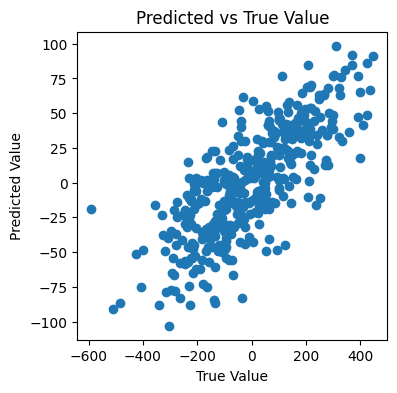

In [24]:
# make prediction 

y_pred = net.predict(X_test)

# plot the output against the target

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Value')
plt.show()

In [25]:
# test pearson correlation 

# calculate pearson correlation

from scipy.stats import pearsonr

corr, _ = pearsonr(y_test.flatten(), y_pred.flatten())

print(f'Pearsons correlation: {corr}')

Pearsons correlation: 0.7669682676823475


## Data Integration Validation 

### Initialisation

In [26]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')
# Bring in CCLE data


Project path set to: c:\Github\ode-biomarker-project


In [27]:
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')


In [28]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features_v2-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [29]:
feature_data

,pIGFR_auc,pIGFR_median,pIGFR_tfc,pIGFR_tmax,pIGFR_max,pIGFR_tmin,pIGFR_min,pIGFR_ttsv,pIGFR_tsv,pIGFR_init,...,amTORC2_auc,amTORC2_median,amTORC2_tfc,amTORC2_tmax,amTORC2_max,amTORC2_tmin,amTORC2_min,amTORC2_ttsv,amTORC2_tsv,amTORC2_init
SIDM01085,0.019410,0.021032,4.682872,0.96,0.032885,0.0,0.005787,0.04,0.005787,0.005787,...,0.001717,0.001599,5.486629,0.96,0.003834,0.00,0.000591,0.04,0.000591,0.000591
SIDM00949,0.077292,0.084704,9.089875,0.96,0.140803,0.0,0.013955,0.04,0.013955,0.013955,...,0.218305,0.226915,0.364546,0.96,0.264206,0.00,0.193622,0.04,0.193622,0.193622
SIDM00494,0.010086,0.011210,3.560627,0.96,0.015136,0.0,0.003319,0.04,0.003319,0.003319,...,0.019850,0.020458,0.403167,0.96,0.024825,0.00,0.017692,0.04,0.017692,0.017692
SIDM00377,0.036978,0.039602,5.138051,0.96,0.065341,0.0,0.010645,0.04,0.010645,0.010645,...,0.000361,0.000332,1.189183,0.96,0.000639,0.00,0.000292,0.04,0.000292,0.000292
SIDM00988,0.027368,0.030932,8.449997,0.96,0.039991,0.0,0.004232,0.04,0.004232,0.004232,...,0.008990,0.009058,0.465354,0.96,0.011839,0.08,0.008078,0.04,0.008079,0.008079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIDM00697,0.013521,0.014763,9.576674,0.96,0.024837,0.0,0.002348,0.04,0.002348,0.002348,...,0.000116,0.000116,0.539425,0.96,0.000160,0.00,0.000104,0.04,0.000104,0.000104
SIDM01188,0.032034,0.036092,11.164995,0.96,0.056863,0.0,0.004674,0.04,0.004674,0.004674,...,0.140425,0.146074,0.332654,0.96,0.167943,0.00,0.126022,0.04,0.126022,0.126022
SIDM00999,0.015288,0.016662,5.579325,0.96,0.026040,0.0,0.003958,0.04,0.003958,0.003958,...,0.002991,0.002788,4.879114,0.96,0.006578,0.00,0.001119,0.04,0.001119,0.001119
SIDM00149,0.078582,0.089001,14.430451,0.96,0.135102,0.0,0.008756,0.04,0.008756,0.008756,...,0.142652,0.147998,0.297572,0.96,0.170342,0.00,0.131277,0.04,0.131277,0.131277


In [30]:
# convert to numpy
feature_data_numpy = feature_data.to_numpy()
label_data_numpy = label_data.to_numpy()
label_data_numpy = label_data_numpy.reshape(-1, 1)

In [31]:
print(feature_data_numpy.shape)
print(label_data_numpy.shape)

(665, 260)
(665, 1)


### Training on all data test 1

In [32]:
group_feat_size = 10
total_feat_size = 260
torch.manual_seed(0)

net = NeuralNetRegressor(
    TorchModel,
    module__group_feat_size=group_feat_size,
    module__total_feat_size=total_feat_size,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss,
    max_epochs=100,
    lr=0.001,
    batch_size=32,
    iterator_train__shuffle=True
)

In [33]:
net.fit(feature_data_numpy, label_data_numpy)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    33053.9213       19.8250  0.1010
      2    16931.7875        9.9286  0.1000
      3     8757.3404        5.8922  0.0980
      4     5343.7950        4.2848  0.0980
      5      685.8830        3.6916  0.1010
      6      269.8084        3.2345  0.1100
      7       24.1567        3.0239  0.1010
      8        2.6646        2.9014  0.0960
      9        2.0168        2.7221  0.1140
     10        1.8903        2.6328  0.1020
     11        1.7704        2.4555  0.0990
     12        1.7113        2.3370  0.1000
     13        1.5975        2.2330  0.0990
     14        1.5232        2.1889  0.1090
     15        1.4965        2.0825  0.1030
     16        1.4336        2.0098  0.0980
     17        1.3903        2.0085  0.1050
     18        1.4326        1.9168  0.0980
     19        1.4419        1.9309  0.0970
     20        1.3153        1.8412  0.1010
     21        1.2874        1.8

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TorchModel(
    (group_layers): ModuleList(
      (0-25): 26 x GroupLayer(
        (fc1): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (fc1): Linear(in_features=26, out_features=13, bias=True)
    (fc_out): Linear(in_features=13, out_features=1, bias=True)
  ),
)

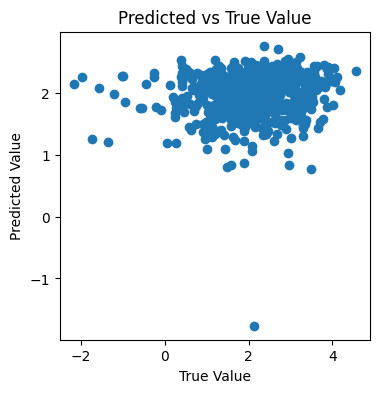

In [34]:
# make prediction 

y_pred = net.predict(feature_data_numpy)

# plot the output against the target

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4, 4))
plt.scatter(label_data_numpy, y_pred)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Predicted vs True Value')
# plt.xlim(-2, 4)
# plt.ylim(0, 4)
plt.show()

In [35]:
# calculate pearson correlation

from scipy.stats import pearsonr

corr, _ = pearsonr(label_data_numpy.flatten(), y_pred.flatten())

print(f'Pearsons correlation: {corr}')

Pearsons correlation: 0.14310619537858338


### Integration with Powerkit

In [36]:
from toolkit import *   

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [37]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))

def pipeline_func(X_train, y_train, rng, **kwargs):
    group_feat_size = 10
    total_feat_size = 260
    torch.manual_seed(rng)

    net = NeuralNetRegressor(
        TorchModel,
        module__group_feat_size=group_feat_size,
        module__total_feat_size=total_feat_size,
        optimizer=torch.optim.Adam,
        criterion=torch.nn.MSELoss,
        max_epochs=20,
        lr=0.001,
        batch_size=32,
        iterator_train__shuffle=True
    )
    
    x_train_numpy = X_train.to_numpy()
    y_train_numpy = y_train.to_numpy()
    y_train_numpy = y_train_numpy.reshape(-1, 1)
    net.fit(x_train_numpy, y_train_numpy)
    return {'model': net}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    
    # preprocess x and y 
    x_test_numpy = X_test.to_numpy()
    y_test_numpy = y_test.to_numpy()
    y_test_numpy = y_test_numpy.reshape(-1, 1)
    
    net = pipeline_components['model']
    y_pred = net.predict(x_test_numpy)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test_numpy.flatten(), y_pred.flatten())
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': None}

In [38]:
powerkit.add_condition('pytorch', False, pipeline_func, {}, eval_func, {})

In [39]:
powerkit.run_selected_condition('pytorch', rngs, n_jobs=1)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.3686        2.2308  0.0910
      2        1.5989        1.7191  0.0900
      3        1.4232        1.5617  0.0910
      4        1.3473        1.4113  0.1030
      5        1.3119        1.4172  0.0880
      6        1.2437        1.2961  0.0860
      7        1.2114        1.3042  0.0870
      8        1.2028        1.2970  0.0860
      9        1.1733        1.2545  0.0860
     10        1.1470        1.2088  0.0850
     11        1.1240        1.1575  0.0850
     12        1.1193        1.1860  0.0860
     13        1.0905        1.1783  0.0860
     14        1.0845        1.2427  0.0850
     15        1.0617        1.1540  0.0900
     16        1.0637        1.1673  0.0900
     17        1.0508        1.1278  0.0850
     18        1.0319        1.1048  0.0930
     19        1.0383        1.0852  0.1030
     20        1.0312        1.1162  0.0870
  epoch    train_loss    valid_l

,rng,condition,model_performance,p_vals
0,0,pytorch,0.141459,0.253515
1,1,pytorch,0.015951,0.898061
2,2,pytorch,0.077332,0.533935
3,3,pytorch,0.133526,0.281383
4,4,pytorch,0.024700,0.842729
5,5,pytorch,0.004248,0.972786
6,6,pytorch,0.000146,0.999064
7,7,pytorch,0.011788,0.924571
8,8,pytorch,-0.023552,0.849952
9,9,pytorch,-0.001878,0.987965


## Initialisation

In [11]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')
# Bring in CCLE data

from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

# load in original ccle data
drug_target = 'FGFR_0939'
dynamic_features_code = 'fgfr4_ccle_dynamic_features_v2'
loading_code = f'generic-gdsc-1-{drug_target}-LN_IC50-{dynamic_features_code}-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)
# convert to numpy
feature_data_numpy = feature_data.to_numpy()
label_data_numpy = label_data.to_numpy()
label_data_numpy = label_data_numpy.reshape(-1, 1)
print(feature_data_numpy.shape)
print(label_data_numpy.shape)

# further config 

group_feat_size = 10
total_feat_size = feature_data.shape[1]

Project path set to: c:\Github\ode-biomarker-project
(665, 260)
(665, 1)


In [16]:
folder_name = "FGFR4-pytorch-model-training"
exp_id = "v1"
fixed_random_seed = 42 # -1 for no seed
save_figure = False
save_data = True
show_figure = False

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [6]:
import torch # type: ignore

if __name__ == "__main__":
    print(torch.__version__)
    # Setup device agnostic code
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

2.3.0+cpu
Using device: cpu


In [8]:
from toolkit import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Run

In [7]:
from skorch import NeuralNetRegressor
from torch import nn  # type: ignore
import torch.nn.functional as F  # type: ignore

class GroupLayer(nn.Module):

    def __init__(self, group_feat_size: int):
        super(GroupLayer, self).__init__()
        self.fc1 = nn.Linear(group_feat_size, 1).double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

class TorchModel(nn.Module):

    def __init__(self, group_feat_size: int, total_feat_size: int):

        super(TorchModel, self).__init__()
        self.group_feat_size = group_feat_size
        self.total_feat_size = total_feat_size

        num_groups = self.total_feat_size // self.group_feat_size

        # if num_groups not an integer, throw error
        if num_groups != self.total_feat_size / self.group_feat_size:
            raise ValueError("Total feature size must be divisible by group feature size")

        self.num_groups = num_groups
        self.group_layers = nn.ModuleList()
        i = 0
        while i < num_groups:
            self.group_layers.append(GroupLayer(group_feat_size))
            i += 1
        self.layer_2_size = int(num_groups / 2)
        self.fc1 = nn.Linear(num_groups, self.layer_2_size).double()
        self.fc_out = nn.Linear(self.layer_2_size, 1).double()


    def forward(self, input_data):

        # print(input_data.shape)

        xs = []
        i = 0
        while i < self.total_feat_size:
            xs.append(input_data[:, i:i+self.group_feat_size])
            i += group_feat_size


        outs = []
        for i, x in enumerate(xs):
            # print(i+1, x.shape)
            outs.append(self.group_layers[i](x))


        x = torch.cat(outs, 1)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x

In [12]:
powerkit = Powerkit(feature_data, label_data)
rngs = list(range(100))

def pipeline_func(X_train, y_train, rng, **kwargs):
    group_feat_size = 10
    total_feat_size = X_train.shape[1]
    torch.manual_seed(rng)

    net = NeuralNetRegressor(
        TorchModel,
        module__group_feat_size=group_feat_size,
        module__total_feat_size=total_feat_size,
        optimizer=torch.optim.Adam,
        criterion=torch.nn.MSELoss,
        max_epochs=500,
        lr=0.001,
        batch_size=32,
        iterator_train__shuffle=True
    )
    
    x_train_numpy = X_train.to_numpy()
    y_train_numpy = y_train.to_numpy()
    y_train_numpy = y_train_numpy.reshape(-1, 1)
    net.fit(x_train_numpy, y_train_numpy)
    return {'model': net}


def eval_func(X_test, y_test, pipeline_components=None, **kwargs):
    
    # preprocess x and y 
    x_test_numpy = X_test.to_numpy()
    y_test_numpy = y_test.to_numpy()
    y_test_numpy = y_test_numpy.reshape(-1, 1)
    
    net = pipeline_components['model']
    y_pred = net.predict(x_test_numpy)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test_numpy.flatten(), y_pred.flatten())
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': None}

In [13]:
powerkit.add_condition('pytorch', False, pipeline_func, {}, eval_func, {})

In [14]:
df = powerkit.run_selected_condition('pytorch', rngs, n_jobs=1)

  0%|          | 0/100 [00:00<?, ?it/s]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       28.1334    83048.5913  0.4229
      2       10.0765    14610.3395  0.1201
      3        3.4216     2410.5324  0.1114
      4        2.1574    13300.9514  0.1280
      5        1.6085     8749.5121  0.1198
      6        1.3651     7557.7609  0.1145
      7        1.2478     7178.2494  0.1153
      8        1.1828     5694.3690  0.1252
      9        1.1511     4093.7305  0.1208
     10        1.1206     4802.5108  0.1722
     11        1.0991     6386.6136  0.1281
     12        1.0774     5602.2282  0.1186
     13        1.0652     6069.3954  0.1117
     14        1.0480     7072.5656  0.1180
     15        1.0450     8125.9363  0.1185
     16        1.0370     8008.1032  0.1109
     17        1.0135     5466.3339  0.1727
     18        1.0199     7230.5917  0.1767
     19        1.0112     8471.5858  0.1193
     20        1.0099     8760.4574  0.1142


  1%|          | 1/100 [00:05<08:52,  5.37s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       14.4865  1145032.7435  0.1144
      2        3.7493  1695689.1332  0.1238
      3        2.1531  1569641.2528  0.1148
      4        1.4926  1292329.9646  0.1177
      5        1.2675  1221798.9880  0.1207
      6        1.2216  1119151.2273  0.1101
      7        1.1559  1024163.6533  0.1091
      8        1.1471   973204.9063  0.1107
      9        1.0983   928794.5715  0.1536
     10        1.0702   877602.9246  0.1539
     11        1.0524   835491.4323  0.1443
     12        1.0555   814129.4787  0.1383
     13        1.0286   781360.1313  0.1410
     14        1.0294   767919.2718  0.1961
     15        1.0425   712257.8423  0.1509
     16        0.9966   724338.3983  0.1217
     17        0.9627   713354.3622  0.1129
     18        0.9607   697192.7190  0.1610
     19        0.9479   673871.1399  0.1408
     20        0.9484   642458.8934  0.1639


  2%|▏         | 2/100 [00:08<06:17,  3.85s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4027.1273        6.5928  0.1277
      2      812.5580        4.5761  0.1485
      3      400.6700        3.7946  0.1195
      4       19.1348        3.1202  0.1108
      5       15.3202        2.4700  0.1133
      6        9.3154        2.0648  0.1165
      7        2.9512        1.8856  0.1205
      8        2.3224        1.7910  0.1183
      9        1.7716        1.6808  0.1099
     10        1.5807        1.5963  0.1255
     11        1.4802        1.5151  0.2039
     12        1.3821        1.4590  0.1283
     13        1.3148        1.4158  0.1155
     14        1.2531        1.3629  0.1189
     15        1.2031        1.3325  0.1301
     16        1.1618        1.3131  0.1140
     17        1.1308        1.2944  0.1157
     18        1.1039        1.2675  0.1146
     19        1.0807        1.2632  0.1055
     20        1.0650        1.2747  0.1108


  3%|▎         | 3/100 [00:10<05:15,  3.25s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1037.2568        2.8599  0.1160
      2      390.6265        2.3857  0.1181
      3      144.3261        1.9439  0.1191
      4       35.6662        1.5684  0.1117
      5        4.1007        1.2697  0.1184
      6        2.1772        1.0971  0.1109
      7        1.2987        1.0160  0.1096
      8        1.2298        0.9630  0.1114
      9        1.1866        0.9313  0.1588
     10        1.1399        0.9107  0.1802
     11        1.1198        0.8904  0.2074
     12        1.1027        0.8695  0.1147
     13        1.0925        0.8512  0.1156
     14        1.0767        0.8494  0.1061
     15        1.0695        0.8513  0.1055
     16        1.0719        0.8275  0.1117
     17        1.0518        0.8301  0.1064
     18        1.0485        0.8230  0.1034
     19        1.0424        0.8097  0.1087
     20        1.0392        0.8101  0.1109


  4%|▍         | 4/100 [00:13<04:43,  2.95s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      702.4704      158.3576  0.1115
      2      264.7259       83.6147  0.1139
      3      140.1869       48.4322  0.1020
      4       74.1780       30.8810  0.1132
      5       47.9113       20.2083  0.1070
      6       33.8137       12.5915  0.1161
      7       18.7079        7.0960  0.1041
      8       10.0500        4.1042  0.1700
      9        6.3526        2.7532  0.1299
     10        4.2167        2.2789  0.1103
     11        3.2273        2.0005  0.1142
     12        2.4315        1.8094  0.1169
     13        1.9940        1.6844  0.1158
     14        1.7415        1.6115  0.1105
     15        1.5583        1.5559  0.1153
     16        1.4195        1.4791  0.1326
     17        1.3390        1.4501  0.1430
     18        1.2806        1.4171  0.1169
     19        1.2631        1.3949  0.1101
     20        1.2276        1.3853  0.1190


  5%|▌         | 5/100 [00:15<04:21,  2.76s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      311.7685      182.4094  0.1322
      2       89.3052       57.5547  0.1412
      3       29.5665       18.3032  0.1509
      4        9.5622        7.8977  0.1091
      5        5.0141        4.2939  0.1468
      6        3.2539        2.9158  0.1318
      7        2.4461        2.1706  0.1118
      8        2.0481        1.7925  0.1195
      9        1.8105        1.5965  0.1499
     10        1.6872        1.4752  0.1085
     11        1.6088        1.4224  0.1202
     12        1.5462        1.3748  0.1089
     13        1.4982        1.3443  0.1051
     14        1.4576        1.3199  0.1109
     15        1.4274        1.3081  0.1091
     16        1.3969        1.2899  0.1001
     17        1.3666        1.2714  0.1134
     18        1.3466        1.2565  0.1274
     19        1.3149        1.2463  0.1092
     20        1.2921        1.2301  0.1244


  6%|▌         | 6/100 [00:18<04:10,  2.66s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      812.9635        1.6057  0.1110
      2      222.3090        1.3214  0.1104
      3        4.2401        1.3516  0.1097
      4        1.4289        1.2598  0.1702
      5        4.7623        1.2263  0.1303
      6        1.8071        1.1737  0.1101
      7        1.5018        1.1674  0.1102
      8        1.4636        1.1703  0.1186
      9        1.2218        1.1527  0.1279
     10        1.1976        1.1178  0.1182
     11        1.1785        1.1466  0.1108
     12        1.1384        1.1518  0.1145
     13        1.1204        1.1188  0.1157
     14        1.1140        1.1147  0.1157
     15        1.1197        1.0867  0.1203
     16        1.0957        1.0960  0.1101
     17        1.0858        1.1024  0.1109
     18        1.1200        1.1118  0.1180
     19        1.0648        1.0775  0.1098
     20        1.0852        1.0927  0.1218


  7%|▋         | 7/100 [00:20<03:59,  2.57s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       11.3950        4.2343  0.1188
      2        2.7915        1.4542  0.1673
      3        1.5524        1.2934  0.1661
      4        1.3189        1.1958  0.1326
      5        1.1721        1.2266  0.1155
      6        1.0905        1.1956  0.1124
      7        1.0674        1.1913  0.1094
      8        1.0348        1.1834  0.1197
      9        1.0108        1.1918  0.1103
     10        0.9982        1.1827  0.1146
     11        0.9815        1.1877  0.1127
     12        0.9759        1.1788  0.1217
     13        1.0097        1.1770  0.1146
     14        0.9640        1.1678  0.1119
     15        0.9629        1.1679  0.1163
     16        1.0021        1.1709  0.1100
     17        1.0118        1.1851  0.1163
     18        1.0440        1.1996  0.1143
     19        0.9699        1.1871  0.1128
     20        0.9443        1.1506  0.1060


  8%|▊         | 8/100 [00:22<03:53,  2.54s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    57215.6559        6.3475  0.1803
      2    17843.5935        3.1927  0.1297
      3      557.1202        2.0729  0.1074
      4       37.8115        1.5463  0.1071
      5      218.9772        1.3081  0.1073
      6       46.2887        1.1968  0.1123
      7        1.2771        1.1154  0.1103
      8       14.0194        1.0651  0.1000
      9        5.2143        1.0373  0.1214
     10        6.0000        1.0310  0.1085
     11        1.1236        1.0274  0.1001
     12        1.1625        1.0239  0.1011
     13        1.0501        1.0219  0.1098
     14        1.0391        1.0200  0.1089
     15        1.0341        1.0193  0.1108
     16        1.0271        1.0187  0.1006
     17        1.0259        1.0158  0.1053
     18        1.0201        1.0178  0.1056
     19        1.0190        1.0197  0.1233
     20        1.0152        1.0167  0.1268


  9%|▉         | 9/100 [00:25<03:44,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    16287.1780        4.7178  0.1660
      2     1645.8173        3.5847  0.1283
      3       18.2065        3.5083  0.1124
      4      100.0556        1.9059  0.1209
      5       33.6979        1.6499  0.1274
      6       22.4527        1.4879  0.1216
      7        6.9682        1.4303  0.1084
      8       32.1208        1.2920  0.1720
      9        2.0534        1.2074  0.1281
     10        7.1565        1.1804  0.1090
     11        1.3683        1.1263  0.1148
     12        2.4989        1.0804  0.1101
     13        2.2181        1.0503  0.1100
     14        1.7983        1.0373  0.1199
     15        1.1832        1.0229  0.1183
     16        3.8930        1.0252  0.1136
     17        4.0210        1.0024  0.1052
     18        2.9578        1.0232  0.1700
     19        1.6402        0.9759  0.1590
     20        1.1030        0.9951  0.1193


 10%|█         | 10/100 [00:27<03:45,  2.51s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.9637        1.3375  0.1966
      2        1.4661        1.2610  0.1316
      3        1.1978        1.1306  0.1185
      4        1.1097        1.1033  0.1115
      5        1.0720        1.0807  0.1125
      6        1.0375        1.0664  0.1071
      7        1.0147        1.0229  0.1113
      8        1.0056        1.0358  0.1125
      9        0.9786        0.9870  0.1085
     10        0.9688        0.9989  0.1168
     11        0.9690        1.0200  0.1192
     12        0.9516        1.0209  0.1113
     13        0.9526        0.9735  0.1090
     14        0.9394        1.0133  0.1178
     15        0.9442        0.9740  0.1132
     16        0.9334        1.0089  0.1751
     17        0.9310        0.9797  0.1501
     18        0.9386        1.0150  0.1182
     19        0.9378        0.9817  0.1107
     20        0.9464        1.0203  0.1140


 11%|█         | 11/100 [00:30<03:43,  2.51s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.8994      550.9790  0.1227
      2        1.5128      125.0774  0.1152
      3        1.3001      357.8555  0.1165
      4        1.2138      276.2114  0.1179
      5        1.1014     1122.3857  0.1105
      6        1.0477     2352.8915  0.1216
      7        1.0263     4269.0736  0.1098
      8        0.9924     5500.3527  0.1075
      9        0.9882     8291.6677  0.1170
     10        0.9702     9330.1579  0.1185
     11        0.9669     9695.2136  0.1113
     12        0.9755    13910.4345  0.1113
     13        0.9546    14653.8911  0.1167
     14        0.9481    15356.5763  0.1274
     15        0.9442    19105.2969  0.1940
     16        0.9437    20681.5324  0.1130
     17        0.9433    22262.3135  0.1112
     18        0.9532    21633.5172  0.1129
     19        0.9385    27557.5059  0.1170
     20        0.9437    26233.4225  0.1116


 12%|█▏        | 12/100 [00:32<03:39,  2.49s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      160.9879       16.6983  0.1191
      2       13.3566       13.0813  0.1243
      3       10.3922        4.1114  0.1170
      4        4.0778        3.4846  0.1187
      5        2.6780        1.8222  0.1143
      6        1.9811        1.3060  0.1072
      7        1.6505        1.2776  0.1057
      8        1.4494        1.0679  0.1112
      9        1.3343        0.9823  0.1199
     10        1.2443        1.0015  0.1022
     11        1.1786        0.9273  0.1111
     12        1.1232        0.9101  0.1100
     13        1.0944        0.9045  0.1502
     14        1.0747        0.8881  0.1385
     15        1.0561        0.8777  0.1141
     16        1.0488        0.8840  0.1171
     17        1.0408        0.8764  0.1110
     18        1.0351        0.8770  0.1189
     19        1.0353        0.8755  0.1239
     20        1.0323        0.8641  0.1128


 13%|█▎        | 13/100 [00:35<03:33,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.3702   173190.6361  0.1193
      2        1.4823    41389.4563  0.1217
      3        1.1556     5028.4489  0.1100
      4        1.0311     3572.1991  0.1140
      5        0.9831    34355.0833  0.1202
      6        0.9486    80815.7127  0.1133
      7        0.9353   137545.5051  0.1105
      8        0.9131   197375.9687  0.1194
      9        0.9055   264222.3904  0.1142
     10        0.8964   327697.3056  0.1221
     11        0.8862   402761.0812  0.1428
     12        0.8828   488968.6249  0.1783
     13        0.8834   583473.5803  0.1123
     14        0.8766   624551.4695  0.1178
     15        0.8698   726239.1345  0.1200
     16        0.8874   890735.3188  0.1091
     17        0.8654   895752.4232  0.1122
     18        0.8777  1027027.4827  0.1061
     19        0.8615  1122287.1748  0.1136
     20        0.8573  1265007.8882  0.1130


 14%|█▍        | 14/100 [00:37<03:31,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     5737.8302        1.2874  0.1279
      2      368.8468        1.1182  0.1295
      3      128.7407        1.0830  0.1107
      4       16.2413        1.0447  0.1185
      5        6.5767        1.0239  0.1105
      6        8.1934        1.0025  0.1210
      7        3.4487        0.9985  0.1164
      8       44.5275        0.9913  0.1108
      9       77.5101        0.9715  0.1116
     10        1.0631        1.0046  0.1971
     11        6.4622        0.9728  0.1343
     12      303.3702        1.0092  0.1135
     13     3175.0480        1.0844  0.1100
     14     2122.6458        0.9401  0.1217
     15       50.4456        1.0110  0.1182
     16      135.0274        0.9666  0.1083
     17      182.3947        0.9531  0.1187
     18      179.1962        1.0094  0.1229
     19       40.8019        0.9524  0.1084
     20        0.9588        0.9890  0.1212


 15%|█▌        | 15/100 [00:40<03:29,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  2142972.8713       13.4922  0.1242
      2  1690658.1047        5.7312  0.1218
      3  1391532.4802        2.8061  0.1127
      4  1178914.9687        2.2447  0.1117
      5   925150.1491        2.2229  0.1107
      6   780085.8109        2.1615  0.1115
      7   674442.6220        2.1106  0.1099
      8   556435.7354        2.0803  0.1367
      9   465914.5047        2.1579  0.1814
     10   406559.5575        2.1165  0.1164
     11   347869.6644        2.1827  0.1256
     12   302949.3632        2.2118  0.1115
     13   249523.6836        2.1388  0.1175
     14   215098.6496        1.9392  0.1199
     15   184556.4040        1.7664  0.1179
     16   164579.2812        1.5804  0.1165
     17   127423.2761        1.4810  0.1134
     18   112354.2206        1.3968  0.1125
     19    91708.4428        1.2939  0.1064
     20    76316.0306        1.2416  0.1109


 16%|█▌        | 16/100 [00:42<03:26,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        7.8572     6251.7654  0.1200
      2        3.3174     8623.3599  0.1195
      3        2.3903     9816.2820  0.1151
      4        1.9682    10195.5567  0.1129
      5        1.7308    10634.4668  0.1913
      6        1.5581    10112.5956  0.1590
      7        1.4204    10599.6228  0.1586
      8        1.3336    10778.4394  0.1214
      9        1.2364    11644.0205  0.1196
     10        1.1779    12102.3738  0.1190
     11        1.1294    12701.7442  0.1213
     12        1.0989    13852.8718  0.1177
     13        1.0695    14609.1020  0.1198
     14        1.0363    16395.2163  0.1158
     15        1.0201    18005.5439  0.1159
     16        1.0052    19596.5475  0.1175
     17        0.9970    21134.7463  0.1114
     18        0.9921    24013.5698  0.1183
     19        0.9782    25911.9485  0.1012
     20        0.9752    28852.8890  0.1203


 17%|█▋        | 17/100 [00:45<03:25,  2.48s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       38.1949        7.5633  0.1211
      2        4.2757        2.7174  0.1192
      3        1.9636        1.8512  0.1100
      4        1.5443        1.6791  0.1212
      5        1.3890        1.6865  0.1940
      6        1.3476        1.6127  0.1351
      7        1.2923        1.5768  0.1100
      8        1.2421        1.5205  0.1174
      9        1.2004        1.4901  0.1210
     10        1.1636        1.4509  0.1149
     11        1.1424        1.4224  0.1109
     12        1.1195        1.4140  0.1140
     13        1.0892        1.4096  0.1088
     14        1.0753        1.3899  0.1111
     15        1.0577        1.3407  0.1097
     16        1.0608        1.3848  0.1297
     17        1.0372        1.3743  0.1173
     18        1.0473        1.3077  0.1085
     19        1.0151        1.3015  0.1147
     20        1.0100        1.3079  0.1148


 18%|█▊        | 18/100 [00:47<03:22,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    36001.6618       13.6395  0.1171
      2    27534.8516        6.2412  0.1254
      3    19030.7990        2.9431  0.1803
      4    13762.6140        1.8499  0.1774
      5    10311.0324        1.9753  0.1098
      6     7728.1805        2.3625  0.1108
      7     4712.0252        2.2526  0.1109
      8     3838.1570        2.3497  0.1109
      9     2309.2325        2.2435  0.1210
     10     1572.5638        2.4677  0.1189
     11      849.0052        2.1142  0.1120
     12      662.9192        2.1863  0.1173
     13      344.7995        2.0628  0.1121
     14      217.4461        1.8779  0.1089
     15      134.7489        1.7748  0.1088
     16       72.1085        1.6932  0.1109
     17       35.2530        1.6478  0.1211
     18       23.4158        1.5810  0.1104
     19       14.1628        1.5103  0.1200
     20       10.2310        1.4482  0.1201


 19%|█▉        | 19/100 [00:49<03:19,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   752444.9840        4.3881  0.1498
      2   646840.1296        2.8490  0.1813
      3   554560.9757        2.3373  0.1194
      4   488946.1855        2.0684  0.1121
      5   409460.1710        1.8928  0.1101
      6   353712.1778        1.7982  0.1224
      7   308952.7768        1.7207  0.1193
      8   279114.8096        1.6548  0.1185
      9   229667.3766        1.6004  0.1220
     10   202712.1315        1.5349  0.1196
     11   178835.4127        1.4981  0.1134
     12   151013.7212        1.4458  0.1064
     13   131131.9897        1.4002  0.1108
     14   127314.6612        1.3925  0.1110
     15    97858.3000        1.3354  0.1289
     16    93884.4670        1.3361  0.1096
     17    73469.0681        1.3039  0.1159
     18    63834.2378        1.2752  0.1101
     19    56329.4968        1.2670  0.1119
     20    49170.8579        1.2347  0.1697


 20%|██        | 20/100 [00:52<03:18,  2.48s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      494.2038      228.4566  0.1317
      2      200.4107       82.3184  0.1236
      3       74.4803       31.9697  0.1052
      4       38.7986       24.5493  0.1201
      5       27.0829       17.4378  0.1214
      6       19.7293       11.4064  0.1105
      7       14.4516        7.4816  0.1118
      8       10.4236        4.7050  0.1126
      9        6.9896        2.7037  0.1059
     10        4.7796        1.8976  0.1150
     11        3.4577        1.6542  0.1126
     12        2.9526        1.5465  0.1186
     13        2.4944        1.5208  0.1262
     14        2.2122        1.4644  0.1122
     15        2.0374        1.4298  0.1118
     16        1.8576        1.4083  0.1100
     17        1.7015        1.3736  0.1185
     18        1.5983        1.3557  0.1147
     19        1.5092        1.3371  0.1998
     20        1.4413        1.3082  0.1293


 21%|██        | 21/100 [00:54<03:16,  2.48s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    39639.2929        2.2233  0.1202
      2     5558.1401        1.3648  0.1246
      3      233.0186        1.1921  0.1222
      4      112.1649        1.1304  0.1149
      5      233.7803        1.1674  0.1104
      6        1.9119        1.0944  0.1053
      7        5.4424        1.0488  0.1200
      8        1.5372        1.0194  0.1292
      9        5.4881        1.0337  0.1219
     10        1.5679        1.0393  0.1117
     11        3.6296        0.9913  0.1080
     12        1.2535        0.9769  0.1202
     13        1.4821        0.9815  0.1154
     14        1.1899        0.9847  0.1159
     15        1.1331        0.9726  0.1101
     16        1.1175        0.9762  0.1068
     17        1.0959        0.9704  0.1698
     18       12.8621        1.0102  0.1690
     19       49.1512        0.9505  0.1185
     20       11.0983        0.9549  0.1147


 22%|██▏       | 22/100 [00:57<03:13,  2.48s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       64.0025   125550.1979  0.1329
      2       22.2318   107380.8746  0.1229
      3        9.8710   216527.2012  0.1168
      4        6.0920   426686.8817  0.1279
      5        4.3799   580260.6523  0.1624
      6        3.4696   501868.4482  0.1186
      7        2.7485   388550.8039  0.1085
      8        2.2530   293671.3073  0.1197
      9        1.9821   269029.6297  0.1144
     10        1.7742   254812.1695  0.1149
     11        1.6035   233595.5380  0.1117
     12        1.4972   214501.3857  0.1201
     13        1.4027   196738.4262  0.1185
     14        1.3481   176146.1997  0.1183
     15        1.2817   170529.6818  0.1800
     16        1.2451   168399.3295  0.1457
     17        1.2148   156544.2507  0.1099
     18        1.1906   153312.4749  0.1162
     19        1.1647   146805.8129  0.1256
     20        1.1406   157511.9381  0.1191


 23%|██▎       | 23/100 [01:00<03:12,  2.50s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   539255.9648       74.0320  0.1338
      2   394134.3654       14.6067  0.1214
      3   381813.0319        4.2026  0.1112
      4   217372.0521        4.0727  0.1149
      5   143208.8755        4.1915  0.1098
      6   103665.6370        6.0298  0.1203
      7    41100.1873        3.0744  0.1141
      8    23830.5127        1.8561  0.1170
      9    14373.3314        1.9755  0.1198
     10     6953.3575        2.0590  0.1404
     11     3475.2454        2.0612  0.1203
     12     1290.2678        2.0331  0.1307
     13      277.0462        1.9419  0.2015
     14       79.3765        1.7976  0.1352
     15       55.3505        1.6503  0.1201
     16        6.7374        1.5400  0.1086
     17        1.9637        1.4615  0.1125
     18        1.3323        1.4082  0.1159
     19        1.1898        1.3622  0.1185
     20        1.1658        1.3367  0.1385


 24%|██▍       | 24/100 [01:02<03:10,  2.51s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    13372.1802        1.7268  0.1069
      2     2310.9857        1.2727  0.1039
      3      824.7776        1.1102  0.1097
      4       15.3809        1.0566  0.1072
      5       98.9238        1.0388  0.1127
      6        3.4551        1.0267  0.1072
      7        1.5545        1.0088  0.1111
      8        1.5247        0.9959  0.0992
      9        1.0687        0.9849  0.1061
     10        1.2292        0.9880  0.1066
     11       20.6121        0.9797  0.1049
     12       31.6613        0.9772  0.1795
     13        1.0524        0.9716  0.1305
     14        2.9351        0.9691  0.1061
     15        1.3455        0.9709  0.1001
     16        0.9471        0.9753  0.1009
     17        1.1339        0.9711  0.1109
     18        0.9387        0.9796  0.1092
     19        1.0540        0.9695  0.1071
     20        0.9815        0.9705  0.1103


 25%|██▌       | 25/100 [01:04<03:03,  2.44s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   601654.9989      197.0087  0.1140
      2   490622.0514       20.3008  0.1154
      3   295005.6035        8.5994  0.1080
      4   217867.3469        7.7583  0.1041
      5   137043.2909        7.5913  0.1065
      6    88326.9900        7.0007  0.1106
      7    70425.5620        6.3874  0.1088
      8    35740.6216        5.5450  0.1032
      9    20756.3924        5.0751  0.1136
     10    12198.7768        4.8041  0.1018
     11     8001.0722        4.6179  0.1337
     12     4237.1349        4.3194  0.1501
     13     1893.7348        4.0857  0.1177
     14     1047.1304        3.9517  0.0988
     15      678.3833        3.7672  0.1084
     16      194.9061        3.6236  0.1132
     17       89.3257        3.4928  0.1080
     18       71.7351        3.3407  0.1100
     19       16.0960        3.2060  0.1060
     20        8.1118        3.0709  0.1236


 26%|██▌       | 26/100 [01:07<02:57,  2.40s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       36.4735   226959.2677  0.1189
      2        9.5747   169236.9150  0.1211
      3        3.9664   160548.3942  0.1315
      4        2.3885   169360.8671  0.1172
      5        1.8071   180835.5399  0.1151
      6        1.5259   199093.6469  0.1107
      7        1.4180   213617.5643  0.1125
      8        1.3336   238952.3993  0.1086
      9        1.2765   260904.2783  0.1105
     10        1.2260   277018.9843  0.1446
     11        1.1906   295980.8542  0.1408
     12        1.1611   309166.1683  0.1150
     13        1.1383   317326.9793  0.1122
     14        1.1409   323674.7696  0.1088
     15        1.1023   329981.8101  0.1187
     16        1.0943   333383.4722  0.1303
     17        1.0733   335497.7202  0.1109
     18        1.0622   333985.7523  0.1190
     19        1.0523   329639.4212  0.1126
     20        1.0428   329267.1300  0.1163


 27%|██▋       | 27/100 [01:09<02:55,  2.40s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      225.1913      113.3804  0.1203
      2       95.1926       31.2676  0.1197
      3       25.1450       12.2591  0.1169
      4       34.1443        7.1153  0.1234
      5       99.9112        4.0658  0.1644
      6       22.2436        3.0444  0.1170
      7        5.7955        2.5457  0.1129
      8        3.4437        2.2843  0.1865
      9        4.3084        1.8631  0.1534
     10        2.3369        1.6087  0.1169
     11        2.0291        1.4874  0.1100
     12        1.8223        1.3588  0.1198
     13        1.6776        1.2874  0.1186
     14        1.9764        1.2101  0.1215
     15        3.8991        1.1979  0.1158
     16        1.4826        1.1697  0.1132
     17        1.5236        1.1156  0.1185
     18        1.3472        1.0981  0.1100
     19        1.3412        1.0778  0.1536
     20        1.2940        1.0469  0.1166


 28%|██▊       | 28/100 [01:12<02:56,  2.45s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       37.0278        1.6956  0.1290
      2      492.7786        1.2877  0.1112
      3       15.3141        1.1263  0.1065
      4       19.0416        1.2008  0.1057
      5        2.5313        1.1031  0.1071
      6        2.8730        1.0454  0.1258
      7        1.6049        1.0498  0.1563
      8        1.3294        1.0230  0.1202
      9        1.4860        0.9896  0.1129
     10        1.3174        0.9562  0.1045
     11        1.2213        0.9275  0.1213
     12        1.1826        0.9225  0.1184
     13        1.1577        0.9229  0.1114
     14        1.1439        0.9067  0.1142
     15        1.1246        0.9040  0.1174
     16        1.1172        0.8984  0.1064
     17        1.1078        0.8838  0.1198
     18        1.0966        0.8778  0.1126
     19        1.0879        0.8938  0.1210
     20        1.0752        0.8629  0.1140


 29%|██▉       | 29/100 [01:14<02:52,  2.44s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    78177.3282       89.7905  0.1172
      2    62670.3354       30.6170  0.1207
      3    39829.8544       12.4037  0.1101
      4    27338.9708        6.5815  0.1189
      5    18036.9162        4.3209  0.2012
      6     9062.8561        3.4275  0.1301
      7     1069.9480        2.9907  0.1279
      8      170.0841        2.6984  0.1154
      9      500.3564        2.5448  0.1146
     10       78.9562        2.4342  0.1190
     11        4.7516        2.3170  0.1199
     12       11.9871        2.2028  0.1418
     13        2.5884        2.1152  0.1131
     14        2.4086        2.0313  0.1215
     15        2.1915        1.9547  0.1176
     16        2.0550        1.8832  0.1113
     17        1.8980        1.8061  0.1098
     18        1.7821        1.7419  0.1128
     19        1.6780        1.6890  0.1129
     20        1.5959        1.6544  0.1157


 30%|███       | 30/100 [01:16<02:51,  2.45s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    12533.8816      215.9717  0.1262
      2     9520.2142       90.6319  0.1193
      3     5946.1319       49.6593  0.2015
      4     4352.4736       37.6861  0.1383
      5     3138.3634       31.4569  0.1160
      6     2666.5363       28.3673  0.1112
      7     1547.2403       25.0429  0.1218
      8     1208.3560       27.4410  0.1186
      9      756.2332       26.6061  0.1111
     10      588.8322       28.3342  0.1101
     11      362.6656       28.3254  0.1188
     12      226.8693       26.2828  0.1131
     13      154.1555       26.4272  0.1062
     14      100.0581       25.7903  0.1195
     15       63.6795       25.9478  0.1160
     16       46.9121       26.4942  0.1039
     17       21.1293       25.5120  0.1108
     18       17.9912       25.7761  0.1118
     19        8.6166       25.4821  0.1130
     20        4.3172       24.8237  0.1149


 31%|███       | 31/100 [01:19<02:48,  2.45s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6901.7629      169.2476  0.1276
      2     2359.3659       61.6366  0.1901
      3      366.9935       31.9336  0.1390
      4     1428.4473       14.8492  0.1115
      5      822.9275       10.8370  0.1193
      6      302.4293        8.0486  0.1148
      7       58.3891        6.6050  0.1159
      8      118.0149        5.5260  0.1153
      9       97.3924        4.7492  0.1102
     10       14.1915        4.0644  0.1086
     11        6.0529        3.6311  0.1173
     12        4.3033        3.2624  0.1126
     13        3.6096        2.9534  0.1106
     14        6.5567        2.8253  0.1107
     15       24.5453        2.5044  0.1131
     16      187.7632        2.6437  0.1152
     17      725.8669        2.1726  0.1099
     18     4729.5996        3.2644  0.1144
     19     6340.1497        1.9929  0.1124
     20     5989.2407        2.6328  0.1294


 32%|███▏      | 32/100 [01:21<02:46,  2.45s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4188.8693       50.6525  0.1829
      2     2123.5112       17.4622  0.1817
      3     1297.6026        8.4997  0.1380
      4      855.8677        5.4496  0.1211
      5      615.6895        3.7241  0.1273
      6      422.0806        2.7997  0.1124
      7      397.7927        2.7545  0.1118
      8      141.0944        2.7703  0.1045
      9       95.0212        2.9357  0.0998
     10       76.4099        3.1187  0.1009
     11       48.5009        3.3356  0.1042
     12       34.4960        3.5049  0.1112
     13       27.2415        3.6383  0.1000
     14       17.5728        3.7544  0.1049
     15       12.6049        3.8993  0.1071
     16       10.1120        3.9979  0.0988
     17        7.2826        4.1439  0.1128
     18        5.0801        4.3111  0.1118
     19        3.8952        4.8076  0.1669
     20        3.0407        5.5503  0.1286


 33%|███▎      | 33/100 [01:24<02:44,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    18240.2466       27.2419  0.1218
      2     2576.5553       11.1335  0.1183
      3      149.7517        5.5005  0.1120
      4      156.3684        3.4013  0.1190
      5      221.2593        2.3682  0.1155
      6       35.4095        1.9690  0.1130
      7       43.5986        1.8577  0.1172
      8        9.0015        1.8225  0.1095
      9        3.6033        1.7840  0.1102
     10        1.2686        1.7563  0.1189
     11        1.1666        1.7284  0.1196
     12        1.1166        1.7249  0.1102
     13        1.0896        1.6884  0.1111
     14        1.0655        1.6810  0.1249
     15        1.0522        1.6434  0.1126
     16        1.0531        1.6452  0.1700
     17        1.0541        1.6360  0.1983
     18        1.0346        1.6053  0.1341
     19        1.0012        1.5742  0.1092
     20        0.9938        1.5740  0.1167


 34%|███▍      | 34/100 [01:26<02:42,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.2773        2.2816  0.1204
      2        1.6237        1.2792  0.1312
      3        1.1829        1.1434  0.1186
      4        1.0431        1.0808  0.1308
      5        1.0053        1.0467  0.1784
      6        0.9864        1.0303  0.1315
      7        0.9625        1.0173  0.1068
      8        0.9544        1.0035  0.1200
      9        0.9420        1.0025  0.1186
     10        0.9305        0.9857  0.1229
     11        0.9280        0.9938  0.1093
     12        0.9217        0.9897  0.1186
     13        0.9066        0.9845  0.1133
     14        0.9105        0.9725  0.1567
     15        0.9106        0.9699  0.1787
     16        0.9016        0.9680  0.1118
     17        0.8948        0.9564  0.1262
     18        0.8936        0.9748  0.1141
     19        0.9065        1.0037  0.1168
     20        0.9204        0.9573  0.1100


 35%|███▌      | 35/100 [01:29<02:42,  2.50s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       14.6863     7156.1762  0.1171
      2        4.9048    57192.0965  0.1289
      3        2.3684   123717.0581  0.1126
      4        1.6854   176881.9875  0.1160
      5        1.4554   235879.1693  0.1202
      6        1.2113   311128.9008  0.1296
      7        1.1022   406793.1821  0.1079
      8        1.0389   450127.2545  0.1113
      9        0.9946   516988.2213  0.1178
     10        0.9631   568272.7483  0.1083
     11        0.9427   605849.2991  0.1103
     12        0.9223   640212.9117  0.1495
     13        0.9094   671448.8367  0.1702
     14        0.9007   710974.3715  0.1243
     15        0.8951   731806.6542  0.1166
     16        0.8904   753070.8665  0.1189
     17        0.8894   738122.8880  0.1098
     18        0.8774   759605.3067  0.1185
     19        0.8738   762408.0543  0.1117
     20        0.8721   741221.0111  0.1186


 36%|███▌      | 36/100 [01:31<02:39,  2.49s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    19248.1110        4.3673  0.1327
      2     8047.2490        2.6957  0.1340
      3     1963.7711        1.8624  0.1113
      4      172.7939        1.4853  0.1173
      5        1.6889        1.3250  0.1121
      6        4.7893        1.2090  0.1103
      7        3.7129        1.1235  0.1081
      8        1.2619        1.0725  0.1124
      9        1.2869        1.0178  0.1160
     10        1.1717        1.0178  0.1107
     11        1.1403        0.9846  0.1902
     12        1.1261        0.9663  0.1498
     13        1.1043        0.9553  0.1200
     14        1.0919        0.9494  0.1111
     15        1.0831        0.9301  0.1207
     16        1.0711        0.9331  0.1239
     17        1.0666        0.9335  0.1130
     18        1.0587        0.9320  0.1202
     19        1.0595        0.9173  0.1229
     20        1.0465        0.9432  0.1176


 37%|███▋      | 37/100 [01:34<02:36,  2.49s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      169.4119  1005528.3276  0.1197
      2       31.6568   586319.1769  0.1172
      3        6.2738   479686.4087  0.1144
      4        4.0796   423572.4313  0.1195
      5        3.5006   411880.2986  0.1124
      6        2.9062   353954.8203  0.1181
      7        2.5602   280836.3561  0.1096
      8        2.1134   223420.0149  0.1114
      9        1.8340   194042.2858  0.1517
     10        1.6769   166991.1724  0.1785
     11        1.4749   154519.7494  0.1184
     12        1.3541   144940.8249  0.1119
     13        1.2686   126604.8014  0.1211
     14        1.2174   119178.9136  0.1236
     15        1.1618   114538.1144  0.1144
     16        1.1494   113820.5302  0.1191
     17        1.1092   105984.7175  0.1443
     18        1.0947    99677.1142  0.1129
     19        1.1002   108221.8999  0.1099
     20        1.0737    90860.5406  0.1188


 38%|███▊      | 38/100 [01:36<02:34,  2.49s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    15776.1121       18.9338  0.1199
      2     3929.0937        9.4232  0.1184
      3      702.7447        6.5198  0.1044
      4       13.6700        4.8388  0.1063
      5       54.7046        4.1365  0.1071
      6       37.7985        3.7068  0.1107
      7        8.8577        3.2967  0.1068
      8        5.4928        2.9843  0.1779
      9        3.5023        2.7643  0.1411
     10        2.3635        2.5929  0.1185
     11        2.1260        2.4186  0.1172
     12        1.9750        2.2729  0.1153
     13        1.8400        2.1432  0.1171
     14        1.7392        2.0215  0.1191
     15        1.6432        1.9336  0.1097
     16        1.5649        1.8326  0.1152
     17        1.4969        1.7557  0.1111
     18        1.4320        1.6861  0.1096
     19        1.3869        1.6299  0.1210
     20        1.3396        1.5767  0.1080


 39%|███▉      | 39/100 [01:39<02:29,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   724609.2738        5.5335  0.1197
      2   564176.1960        3.0336  0.1712
      3   497537.4466        3.4406  0.1122
      4   397096.6933        2.3393  0.1122
      5   320590.2227        1.7594  0.1149
      6   273504.6611        1.5933  0.2002
      7   234192.2888        1.5488  0.1320
      8   199023.5275        1.4963  0.1112
      9   163056.5106        1.4152  0.1114
     10   139444.3087        1.3441  0.1109
     11   123433.4613        1.4005  0.1196
     12   103651.6677        1.3445  0.1148
     13    87961.2025        1.2853  0.1109
     14    75862.0626        1.2216  0.1104
     15    65428.0618        1.2656  0.1184
     16    56371.5791        1.2436  0.1192
     17    52838.4731        1.1452  0.1118
     18    42314.8454        1.0996  0.1200
     19    34909.7362        1.2575  0.1099
     20    30255.1203        1.1957  0.1136


 40%|████      | 40/100 [01:41<02:28,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   231986.9597        2.4989  0.1155
      2   214220.2299        2.4360  0.1296
      3    50695.3912        1.9388  0.1302
      4    25458.9028        1.7788  0.1447
      5     4555.3012        1.7120  0.1764
      6      879.0209        1.6629  0.1148
      7      222.0814        1.6088  0.1114
      8       22.7980        1.5865  0.1086
      9        2.5617        1.5391  0.1211
     10        2.9975        1.4991  0.1092
     11        2.8611        1.4714  0.1113
     12        1.6916        1.4293  0.1075
     13        1.4072        1.3954  0.1100
     14        1.3643        1.3693  0.1077
     15        1.3389        1.3498  0.1199
     16     1461.7399        1.3672  0.1194
     17        8.5899        1.3588  0.1112
     18      673.6880        1.2716  0.1218
     19       58.2664        1.2246  0.1158
     20        9.9414        1.1976  0.1110


 41%|████      | 41/100 [01:44<02:25,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        7.8523        3.2269  0.1141
      2        2.3010        2.3723  0.1260
      3        1.8961        1.8434  0.1923
      4        1.5554        1.5941  0.1391
      5        1.4051        1.4820  0.1083
      6        1.2957        1.3614  0.1117
      7        1.1942        1.3058  0.1187
      8        1.1101        1.2639  0.1213
      9        1.0560        1.2297  0.1147
     10        1.0285        1.2189  0.1130
     11        1.0171        1.1977  0.1104
     12        1.0097        1.2658  0.1096
     13        0.9996        1.1989  0.1114
     14        1.0008        1.2208  0.1110
     15        0.9884        1.2051  0.1219
     16        0.9898        1.2137  0.1218
     17        0.9806        1.1954  0.1137
     18        0.9840        1.1770  0.1086
     19        0.9745        1.1951  0.1184
     20        0.9807        1.2152  0.1114


 42%|████▏     | 42/100 [01:46<02:22,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    80531.0938      978.5050  0.1514
      2    64600.2539      396.9413  0.1796
      3    58477.8839      197.0089  0.1260
      4    47742.4692      109.7021  0.1107
      5    41861.8164       75.1270  0.1157
      6    34913.0702       53.3730  0.1126
      7    31444.7927       43.8394  0.1171
      8    27199.0585       36.2213  0.1100
      9    24765.2269       31.5363  0.1127
     10    20560.2134       25.2493  0.1123
     11    20066.1257       20.4427  0.1200
     12    16221.8573       14.4436  0.1175
     13    15053.4240       12.5882  0.1106
     14    13461.1466       11.1085  0.1195
     15    11755.6650       10.1239  0.1134
     16    10859.2785        9.5522  0.1160
     17     9813.3582        9.2048  0.1100
     18     9011.6987        8.7906  0.1097
     19     7902.8742        8.0574  0.1102
     20     7246.9351        7.5075  0.1698


 43%|████▎     | 43/100 [01:49<02:20,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       18.7227        5.8560  0.1426
      2        4.2677        3.2288  0.1282
      3        2.3345        1.9632  0.1117
      4        1.8640        1.7151  0.1111
      5        1.6580        1.5805  0.1117
      6        1.5187        1.4267  0.1190
      7        1.4217        1.3156  0.1197
      8        1.3488        1.2224  0.1214
      9        1.2874        1.1601  0.1182
     10        1.2458        1.0810  0.1118
     11        1.1902        1.0468  0.1184
     12        1.1660        0.9928  0.1105
     13        1.1398        0.9745  0.1092
     14        1.1212        0.9494  0.1141
     15        1.1055        0.9384  0.1113
     16        1.0952        0.9294  0.1066
     17        1.0915        0.9090  0.1216
     18        1.0811        0.9143  0.1175
     19        1.0770        0.8934  0.1909
     20        1.0592        0.9077  0.1304


 44%|████▍     | 44/100 [01:51<02:18,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   252661.9899        5.9922  0.1199
      2   187495.6270        3.4144  0.1255
      3   155356.3388        2.3575  0.1268
      4   111447.3764        1.8581  0.1218
      5    95506.3288        1.4444  0.1127
      6    73905.0318        1.3986  0.1123
      7    60760.2589        1.5354  0.1161
      8    44052.6099        1.6010  0.1098
      9    34160.9878        1.7442  0.1202
     10    30409.7886        1.6791  0.1130
     11    17952.8266        1.5606  0.1171
     12    11981.8829        1.1690  0.1079
     13     8132.7889        1.1194  0.1212
     14     4706.7413        1.0882  0.1054
     15     4012.5781        1.0880  0.1110
     16     1313.0856        1.0671  0.1113
     17      726.5691        1.0584  0.1700
     18      525.0457        1.0540  0.1619
     19      185.4639        1.0444  0.1169
     20       58.1180        1.0322  0.1184


 45%|████▌     | 45/100 [01:54<02:16,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      155.1159   188693.3792  0.1229
      2       38.0286   424301.4883  0.1277
      3       12.2639   348307.0602  0.1111
      4        6.0484   176883.1210  0.1107
      5        3.8347    81623.2570  0.1102
      6        2.9465    32226.9215  0.1202
      7        2.5435     7208.6227  0.1140
      8        2.2662        4.4084  0.1095
      9        2.0594     5357.3379  0.1167
     10        1.8978    27676.9067  0.1154
     11        1.7618    61087.1122  0.1114
     12        1.6463    91150.4980  0.1209
     13        1.5499   136743.1177  0.1693
     14        1.4606   166572.7607  0.1203
     15        1.3957   205875.0538  0.1698
     16        1.3279   246373.4721  0.1786
     17        1.2775   263694.1818  0.1295
     18        1.2247   299522.6255  0.1703
     19        1.1834   298704.8252  0.1388
     20        1.1442   336520.6669  0.1232


 46%|████▌     | 46/100 [01:56<02:15,  2.52s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    18970.7381        3.7015  0.1300
      2     3387.2954        2.4903  0.1240
      3      126.9339        2.1255  0.1152
      4        4.0827        1.9877  0.1170
      5       21.8013        1.9528  0.1139
      6        7.7599        1.9248  0.1211
      7        2.3638        1.8500  0.1150
      8        2.0774        1.8031  0.1113
      9        1.8189        1.7738  0.1306
     10        1.7714        1.7236  0.1102
     11        1.6901        1.6560  0.1179
     12        1.6404        1.6067  0.1288
     13        1.5791        1.5764  0.1584
     14        1.5453        1.5707  0.1101
     15        1.4928        1.5166  0.1106
     16      114.2488        1.4921  0.1091
     17      239.5795        1.4679  0.1116
     18       16.4279        1.4637  0.1098
     19        7.4088        1.4530  0.1128
     20       13.3490        1.4108  0.1060


 47%|████▋     | 47/100 [01:59<02:11,  2.48s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    46088.2818        1.4651  0.1068
      2    29846.0539        1.1640  0.1169
      3    19751.2086        1.0870  0.1051
      4    14823.7551        1.0915  0.1082
      5     7908.0332        1.0827  0.1079
      6     6773.6524        1.1061  0.1025
      7     2364.0887        1.1032  0.1084
      8     1689.3275        1.1046  0.1108
      9      562.6812        1.0937  0.1129
     10      354.8835        1.0771  0.1011
     11      114.1564        1.0755  0.1092
     12       44.1882        1.0514  0.1419
     13        8.8905        1.0446  0.1460
     14        2.1517        1.0175  0.1105
     15        7.1874        1.0073  0.1062
     16        0.9571        1.0153  0.1012
     17        1.1258        1.0150  0.1101
     18        1.0390        1.0253  0.1133
     19        0.9554        1.0152  0.1085
     20        0.9176        1.0104  0.1082


 48%|████▊     | 48/100 [02:01<02:05,  2.42s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       20.9940   256456.6209  0.1100
      2        4.3286   331659.1481  0.1135
      3        2.0460   365457.6388  0.0966
      4        1.6900   365056.4665  0.1076
      5        1.4316   422471.1309  0.1092
      6        1.3302   486910.9842  0.1217
      7        1.2180   560090.3143  0.1067
      8        1.1521   615617.9372  0.1074
      9        1.1074   645202.1369  0.1019
     10        1.0928   736721.0928  0.1119
     11        1.0511   758684.3926  0.1175
     12        1.0152   814025.6377  0.1621
     13        1.0029   899582.2620  0.1315
     14        0.9949   945338.3352  0.1216
     15        0.9674  1058276.1344  0.1223
     16        0.9629  1115742.6059  0.1138
     17        0.9616  1127033.8802  0.1216
     18        0.9644  1207848.2613  0.1123
     19        0.9452  1259270.2890  0.1147
     20        0.9380  1243652.0008  0.1130


 49%|████▉     | 49/100 [02:03<02:02,  2.41s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    37040.6828      167.1799  0.1199
      2    21320.8843       62.7691  0.1407
      3    17308.8322       33.0473  0.1281
      4     5582.0663       20.5285  0.1105
      5     2923.2092       14.3674  0.1126
      6      708.5132        9.6250  0.1125
      7       10.0418        6.7173  0.1096
      8       21.8297        5.2978  0.1082
      9        6.9927        4.5542  0.1499
     10        6.4971        3.9883  0.1813
     11        4.9624        3.6136  0.1267
     12        4.4645        3.3870  0.1122
     13        4.1461        3.2076  0.1177
     14        3.9051        3.0525  0.1204
     15        3.7199        2.9555  0.1189
     16        3.5474        2.8515  0.1101
     17        3.4066        2.7626  0.1212
     18        3.2867        2.6854  0.1843
     19        3.1807        2.6290  0.1358
     20        3.0719        2.5286  0.1384


 50%|█████     | 50/100 [02:06<02:03,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       82.7122  1882330.0080  0.1547
      2       32.0290  1269783.2846  0.1401
      3       11.5693  1028647.7739  0.1202
      4        5.1530   904150.1554  0.1182
      5        2.8970   853323.6947  0.1297
      6        2.3608   814932.1045  0.1987
      7        1.9467   790320.4298  0.1418
      8        1.6897   738216.0361  0.1099
      9        1.5044   708796.0440  0.1182
     10        1.3734   673620.2461  0.1181
     11        1.2732   651776.4871  0.1204
     12        1.2072   625926.8626  0.1095
     13        1.1804   602020.7519  0.1325
     14        1.1416   580243.5087  0.1313
     15        1.1080   549537.0772  0.1159
     16        1.0874   528433.7280  0.1101
     17        1.0790   517489.4038  0.1134
     18        1.0610   475660.1985  0.1077
     19        1.0475   397814.8471  0.1123
     20        1.0359   349607.8002  0.1201


 51%|█████     | 51/100 [02:08<02:02,  2.50s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   205293.4053     2647.2925  0.1177
      2   154793.5083      785.6968  0.1245
      3   112744.6833      117.3274  0.1145
      4    85327.3992       38.1275  0.1877
      5    59964.8209       31.9756  0.1421
      6    43716.6833       19.0526  0.1145
      7    25699.5366       15.8193  0.1103
      8    17447.3809       13.3625  0.1286
      9    14914.6625       11.6463  0.1193
     10     6056.7187       10.0201  0.1159
     11     2692.1626        8.9816  0.1146
     12     1621.2669        7.9040  0.1122
     13      680.4759        7.1782  0.1145
     14      330.2616        6.4817  0.1094
     15      210.4753        5.9228  0.1114
     16       54.4918        5.4351  0.1102
     17       20.9041        5.0614  0.1111
     18       10.1748        4.6762  0.1248
     19        6.0469        4.3243  0.1182
     20        5.4148        4.0416  0.1246


 52%|█████▏    | 52/100 [02:11<01:59,  2.50s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    32054.0727       17.3888  0.1648
      2     3298.0456        8.1760  0.2555
      3       80.5898        5.3197  0.1569
      4      115.2071        3.5662  0.1185
      5       64.9318        2.9556  0.1100
      6       29.7879        2.2428  0.1101
      7        2.4052        1.7349  0.1200
      8        2.9431        1.5316  0.1124
      9        1.6500        1.4499  0.1132
     10        1.6332        1.3703  0.1142
     11        1.4547        1.2987  0.1161
     12        1.4667        1.2767  0.1330
     13        1.4043        1.2698  0.1111
     14        1.3424        1.2061  0.1101
     15        1.2940        1.1795  0.1188
     16        1.2944        1.1504  0.1114
     17        6.6667        1.1598  0.1200
     18       31.4334        1.2121  0.1099
     19        4.1152        1.1010  0.1107
     20       12.9326        1.1009  0.1541


 53%|█████▎    | 53/100 [02:14<01:59,  2.54s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   180914.4853       28.2698  0.1694
      2   122638.6247       22.1714  0.1279
      3    77348.2184       17.9106  0.1113
      4    39821.6653       12.9410  0.1200
      5    27648.5483       10.7021  0.1104
      6    13033.1934        9.3342  0.1147
      7     4719.9740        6.7764  0.1142
      8     1790.0851        4.1384  0.1156
      9      728.2384        3.6794  0.1200
     10      182.5023        2.9329  0.1099
     11       79.0712        2.6105  0.1130
     12       15.1790        2.3348  0.1173
     13        4.1370        2.0791  0.1139
     14        3.3774        1.8804  0.1119
     15        3.0539        1.7424  0.1099
     16        2.8419        1.6440  0.1104
     17        2.6347        1.5519  0.1232
     18        2.4591        1.4365  0.1143
     19        2.3146        1.3488  0.2012
     20        2.2027        1.2835  0.1253


 54%|█████▍    | 54/100 [02:16<01:56,  2.53s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      118.6081       35.4102  0.1284
      2       18.5044        5.2115  0.1202
      3        3.8903        2.1250  0.1327
      4        2.5154        1.6718  0.1380
      5        1.8991        1.1869  0.1119
      6        1.5630        1.0087  0.1129
      7        1.4290        0.9740  0.1101
      8        1.3755        0.9583  0.1156
      9        1.3079        0.9481  0.1096
     10        1.2615        0.9280  0.1092
     11        1.2248        0.9075  0.1149
     12        1.1753        0.9045  0.1189
     13        1.1410        0.8900  0.1198
     14        1.1233        0.8633  0.1192
     15        1.0768        0.8535  0.1102
     16        1.0602        0.8582  0.1108
     17        1.0455        0.8409  0.1989
     18        1.0155        0.8375  0.1291
     19        1.0073        0.8253  0.1115
     20        0.9913        0.8206  0.1165


 55%|█████▌    | 55/100 [02:19<01:53,  2.52s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.0203        2.0696  0.1207
      2        2.0803        1.1393  0.1188
      3        1.5146        0.9524  0.1100
      4        1.3801        0.9357  0.1160
      5        1.3182        0.9066  0.1087
      6        1.2720        0.8769  0.1131
      7        1.2237        0.8626  0.1128
      8        1.1893        0.8508  0.1056
      9        1.1391        0.8442  0.1505
     10        1.1017        0.8496  0.1099
     11        1.0682        0.8368  0.1073
     12        1.0528        0.8446  0.1189
     13        1.0275        0.8372  0.1158
     14        1.0047        0.8503  0.1136
     15        0.9928        0.8789  0.1720
     16        0.9889        0.8757  0.1614
     17        0.9673        0.9281  0.1242
     18        0.9613        0.8917  0.1160
     19        0.9566        0.9083  0.1354
     20        0.9519        0.9076  0.1149


 56%|█████▌    | 56/100 [02:21<01:50,  2.51s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2815.1046        4.5216  0.1319
      2        4.7253        2.2376  0.1253
      3       85.8286        1.7441  0.1070
      4        5.3209        1.5309  0.1210
      5       16.6272        1.3983  0.1100
      6      137.1342        1.3906  0.1056
      7      143.8905        1.3163  0.0990
      8      687.7694        1.4302  0.1158
      9      670.6852        1.2836  0.1055
     10      265.5122        1.2721  0.1103
     11        8.7169        1.3832  0.1099
     12      524.2257        1.2598  0.1073
     13      362.3825        1.3244  0.1090
     14      190.9054        1.2317  0.1627
     15       69.0290        1.2544  0.1207
     16       17.0281        1.2299  0.1108
     17        2.3849        1.2367  0.1073
     18        1.4005        1.2256  0.1094
     19        1.4608        1.2230  0.1189
     20        1.2270        1.2167  0.1098


 57%|█████▋    | 57/100 [02:23<01:45,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   229317.3166        3.3138  0.1208
      2   131457.0193        3.0468  0.1300
      3    96232.7915        2.7916  0.1083
      4    58520.6074        2.5858  0.1063
      5    36895.2201        2.3467  0.1035
      6    19813.9490        1.8612  0.1099
      7     7977.5283        1.6915  0.1081
      8     2594.8508        1.7006  0.1112
      9     1356.0193        1.6830  0.1022
     10      247.8560        1.5728  0.1103
     11       88.7988        1.4972  0.1097
     12        1.8967        1.4422  0.1079
     13        1.5795        1.4281  0.1315
     14        1.5504        1.3656  0.1430
     15        1.4060        1.3510  0.1241
     16        1.3505        1.3355  0.1071
     17        1.3177        1.2893  0.1105
     18        1.2872        1.2726  0.1198
     19        1.2687        1.2579  0.1301
     20        1.2426        1.2217  0.1754


 58%|█████▊    | 58/100 [02:26<01:42,  2.44s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       16.1935        8.2247  0.1378
      2        4.6940        3.4655  0.1217
      3        2.3645        2.5592  0.1174
      4        1.8476        2.1381  0.1140
      5        1.6043        1.7332  0.1109
      6        1.4884        1.5563  0.1163
      7        1.3708        1.3876  0.1211
      8        1.2838        1.2938  0.1145
      9        1.2357        1.2278  0.1155
     10        1.1919        1.1769  0.1147
     11        1.1589        1.1400  0.1969
     12        1.1300        1.1018  0.1360
     13        1.1186        1.0611  0.1100
     14        1.1153        1.0736  0.1306
     15        1.0715        1.0351  0.1207
     16        1.0547        1.0259  0.1150
     17        1.0515        1.0051  0.1199
     18        1.0357        1.0159  0.1143
     19        1.0262        0.9987  0.1157
     20        1.0309        0.9934  0.1124


 59%|█████▉    | 59/100 [02:28<01:40,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    16447.9916       13.3437  0.1872
      2     4881.7183       11.3525  0.1302
      3     3147.7282        8.7033  0.1110
      4      436.9249        6.1957  0.1085
      5      100.6121        4.2561  0.1185
      6       60.2484        2.6636  0.1103
      7        2.2747        1.8423  0.1129
      8        7.0045        1.6100  0.1084
      9     1523.9977        1.6643  0.2038
     10      593.8541        1.5826  0.1502
     11       45.6665        1.4113  0.1070
     12      109.1532        1.3502  0.1192
     13      169.9455        1.3273  0.1198
     14      114.2615        1.2816  0.1130
     15       18.5249        1.2582  0.1149
     16        4.2994        1.2304  0.1109
     17        5.2202        1.2109  0.1187
     18        2.2845        1.1981  0.1199
     19        2.0807        1.1864  0.1196
     20        2.6127        1.1717  0.1342


 60%|██████    | 60/100 [02:31<01:39,  2.49s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      182.6740     5070.6043  0.1418
      2       49.3446     7119.7791  0.1259
      3        6.7520      995.2454  0.1320
      4        1.6591    42084.7015  0.1328
      5        1.6041    37966.0251  0.1202
      6        1.3721    14021.7802  0.1759
      7        1.2572     7201.9718  0.1399
      8        1.2148     3649.1571  0.1056
      9        1.1867     1232.8068  0.1092
     10        1.1549     8943.1618  0.1089
     11        1.1311    17908.9323  0.1109
     12        1.1122    10478.5511  0.1072
     13        1.0970    24144.7398  0.1120
     14        1.0875    26872.1268  0.1091
     15        1.0763    22745.5045  0.1070
     16        1.0680    31302.3985  0.1104
     17        1.0604    18534.0619  0.1080
     18        1.0575    27912.8010  0.1081
     19        1.0484    18744.2342  0.1078
     20        1.0477    18982.0176  0.1083


 61%|██████    | 61/100 [02:33<01:36,  2.48s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        7.2102  1977870.4430  0.1075
      2        3.4036  1668952.9547  0.1194
      3        2.1556  1834520.5080  0.1225
      4        1.6261  1559130.2476  0.1049
      5        1.3939  1546432.7563  0.1300
      6        1.1967  1375459.7303  0.1498
      7        1.1409  1122624.3953  0.1124
      8        1.0239   818583.6045  0.1072
      9        0.9882   679308.9165  0.1103
     10        0.9446   524308.6728  0.1096
     11        0.9308   402799.3604  0.1086
     12        0.9182   311069.1024  0.1072
     13        0.9642   240442.4231  0.1098
     14        0.9086   214172.5729  0.1075
     15        0.8824   134000.7452  0.1023
     16        0.8983   111995.5256  0.1067
     17        0.8670   111424.0883  0.1096
     18        0.8857    96252.3656  0.1102
     19        0.8514    99086.0992  0.1055
     20        0.8643    78978.0161  0.1267


 62%|██████▏   | 62/100 [02:36<01:32,  2.43s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.5449        1.8097  0.1178
      2        1.7202        1.1529  0.1121
      3        1.2741        1.0384  0.1181
      4        1.1192        0.9774  0.1301
      5        1.0667        0.9349  0.1715
      6        1.0045        0.8866  0.1220
      7        0.9817        0.8803  0.1061
      8        0.9686        0.8688  0.1178
      9        0.9699        0.8685  0.1097
     10        0.9652        0.8552  0.1163
     11        0.9465        0.8492  0.1082
     12        0.9525        0.8416  0.1069
     13        0.9510        0.8431  0.1104
     14        0.9323        0.8554  0.1084
     15        0.9313        0.8395  0.1011
     16        0.9407        0.8452  0.1094
     17        0.9275        0.8412  0.1196
     18        0.9326        0.8247  0.1142
     19        0.9208        0.8615  0.1105
     20        0.9343        0.8771  0.1058


 63%|██████▎   | 63/100 [02:38<01:28,  2.41s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     1966.8316        1.9793  0.1123
      2      526.4039        1.5083  0.1111
      3       61.4398        1.3580  0.1164
      4        1.4261        1.2011  0.1703
      5        6.3394        1.1090  0.1312
      6       37.2209        1.0323  0.1186
      7        4.5602        0.9389  0.1113
      8        2.4284        0.9239  0.1130
      9        2.9861        0.9100  0.1157
     10        1.7143        0.8773  0.1129
     11        1.1081        0.8658  0.1186
     12        1.1179        0.8596  0.1102
     13        1.1138        0.8550  0.1110
     14        1.1406        0.8535  0.1226
     15        1.1147        0.8417  0.1118
     16        1.0708        0.8398  0.1111
     17        1.0820        0.8199  0.1075
     18        1.1231        0.8888  0.1106
     19        1.3153        0.8215  0.1087
     20        1.6010        0.8293  0.1171


 64%|██████▍   | 64/100 [02:40<01:26,  2.40s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     6674.9997       45.0355  0.1212
      2      162.5371       24.0916  0.1898
      3       20.5091       11.8088  0.1358
      4      165.9207        6.3994  0.1142
      5       14.3456        4.2114  0.1113
      6      188.2099        2.9842  0.1185
      7      110.9947        2.2482  0.1398
      8       24.6272        1.7924  0.1146
      9        3.8780        1.5058  0.1145
     10       12.0239        1.3298  0.1292
     11        5.0256        1.1559  0.1098
     12        2.7513        1.0857  0.1122
     13        2.7142        1.0229  0.1120
     14        2.6653        0.9519  0.1110
     15        2.9875        0.9054  0.1147
     16        2.5766        0.9252  0.1414
     17        2.3792        0.9197  0.1570
     18        2.9567        0.8914  0.1456
     19        4.0679        0.9045  0.1188
     20       10.1613        0.9019  0.2188


 65%|██████▌   | 65/100 [02:43<01:26,  2.48s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      265.1525   649837.3857  0.1341
      2       94.8719   864123.0787  0.1410
      3       29.3205   859564.1777  0.1728
      4        8.3872   867110.8068  0.1668
      5        3.2522   850558.0620  0.1124
      6        2.1596   823162.9744  0.1227
      7        1.9343   796987.9813  0.1158
      8        1.7797   792944.6753  0.1113
      9        1.6431   763736.1480  0.1201
     10        1.5625   742579.4002  0.1335
     11        1.4958   710873.1814  0.1661
     12        1.4627   694005.1833  0.1601
     13        1.4197   667538.5640  0.1633
     14        1.3777   658681.2061  0.1649
     15        1.3627   634524.6852  0.2175
     16        1.3217   615487.8482  0.2101
     17        1.3004   595228.0430  0.1481
     18        1.2727   580023.7465  0.1302
     19        1.2596   566498.7265  0.1272
     20        1.2332   558018.3709  0.1402


 66%|██████▌   | 66/100 [02:46<01:29,  2.64s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     3226.4152        2.7901  0.1754
      2      641.5009        2.2086  0.1807
      3       20.4228        1.4416  0.1186
      4       73.2880        1.1922  0.1263
      5        1.3097        1.1000  0.1346
      6        1.1393        1.0554  0.1199
      7        1.6286        1.0233  0.1244
      8        1.0556        1.0130  0.1247
      9        1.1208        0.9917  0.1298
     10        1.0336        0.9729  0.1220
     11        1.0247        0.9655  0.2033
     12        1.0071        0.9477  0.1683
     13        1.0062        0.9527  0.1306
     14        0.9971        0.9428  0.1223
     15        0.9896        0.9328  0.1159
     16        0.9867        0.9321  0.1174
     17        0.9848        0.9479  0.1101
     18        0.9781        0.9288  0.1128
     19        0.9744        0.9495  0.1121
     20        0.9792        0.9374  0.1186


 67%|██████▋   | 67/100 [02:49<01:28,  2.67s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    13252.8550        1.1481  0.1308
      2    10263.0825        1.1933  0.1213
      3     6788.2090        1.0958  0.1089
      4     4769.8287        1.0784  0.1329
      5     3615.6357        1.1211  0.1542
      6     2723.7124        1.0739  0.1285
      7     2128.1220        1.0828  0.1587
      8     1743.5939        1.0765  0.2316
      9     1283.1678        1.0659  0.1998
     10     1003.7174        1.0942  0.1282
     11      863.5020        1.0639  0.1310
     12      668.4444        1.0671  0.1184
     13      554.6128        1.0588  0.1204
     14      540.3736        1.0825  0.1106
     15      370.0522        1.0554  0.1192
     16      305.7727        1.0497  0.1114
     17      245.4876        1.0590  0.1086
     18      201.2513        1.0583  0.0997
     19      182.5540        1.0528  0.1019
     20      147.4202        1.0565  0.1091


 68%|██████▊   | 68/100 [02:51<01:25,  2.67s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       22.4058        4.3606  0.1253
      2     1695.0891        1.4732  0.1498
      3        2.8451        1.2496  0.1413
      4      113.5772        1.2366  0.1655
      5       42.9979        1.1977  0.2345
      6        1.4441        1.2102  0.1783
      7        1.3973        1.2098  0.1645
      8        1.5660        1.2153  0.1310
      9        1.8192        1.2030  0.1244
     10        2.2654        1.1910  0.1160
     11        2.9784        1.1913  0.1242
     12        1.0727        1.1729  0.1224
     13       14.0019        1.1706  0.1163
     14       54.5041        1.1834  0.1738
     15        1.8451        1.1502  0.2107
     16      250.4568        1.3615  0.1492
     17      603.0796        1.1524  0.1623
     18      916.2915        1.3218  0.1502
     19      790.9725        1.1922  0.1204
     20      157.9888        1.1574  0.1996


 69%|██████▉   | 69/100 [02:55<01:26,  2.80s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.3676        1.5261  0.1630
      2        1.9396        1.3733  0.1325
      3        1.7267        1.2842  0.1391
      4        1.5601        1.2412  0.1370
      5        1.4340        1.2027  0.1252
      6        1.3272        1.1213  0.1124
      7        1.2560        1.0842  0.1586
      8        1.1901        1.0586  0.1739
      9        1.1515        1.0387  0.1341
     10        1.1087        0.9981  0.1377
     11        1.0823        0.9853  0.1491
     12        1.0644        0.9647  0.1104
     13        1.0441        0.9617  0.1187
     14        1.0418        0.9497  0.1116
     15        1.0233        0.9389  0.1184
     16        1.0096        0.9430  0.1496
     17        1.0116        0.9209  0.1702
     18        0.9910        0.9411  0.1222
     19        0.9899        0.9258  0.1227
     20        0.9809        0.9095  0.1186


 70%|███████   | 70/100 [02:57<01:23,  2.79s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      246.2570      107.4308  0.1201
      2       53.9080       20.9045  0.1298
      3        9.9270        5.5755  0.1259
      4        3.3504        3.6174  0.1058
      5        2.7452        3.1491  0.1192
      6        2.4234        2.7525  0.1102
      7        2.2210        2.5248  0.1110
      8        2.0823        2.3391  0.1189
      9        1.9303        2.2088  0.1142
     10        1.8177        2.0665  0.1149
     11        1.7003        1.9298  0.1713
     12        1.6041        1.8464  0.1187
     13        1.5175        1.7428  0.1109
     14        1.4456        1.6312  0.1715
     15        1.3774        1.5526  0.1485
     16        1.3207        1.4851  0.1099
     17        1.2737        1.4315  0.1063
     18        1.2338        1.3764  0.1217
     19        1.1988        1.3452  0.1287
     20        1.1741        1.2687  0.1099


 71%|███████   | 71/100 [03:00<01:18,  2.71s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    16535.7194        6.9730  0.1222
      2     3479.2372        6.6228  0.1916
      3      161.8993        6.0413  0.1168
      4        6.1674        5.4828  0.1101
      5       22.6388        5.1689  0.1093
      6       11.0572        5.0662  0.1154
      7        4.5534        4.9528  0.1145
      8        4.4766        4.8810  0.1112
      9        3.6145        4.8634  0.1122
     10        3.3365        4.8013  0.1099
     11        3.1714        4.6693  0.1115
     12        3.0280        4.7844  0.1656
     13        2.9214        4.7318  0.1600
     14        2.8498        4.6887  0.1204
     15        2.7420        4.6725  0.1180
     16        2.6560        4.6047  0.1103
     17        2.5724        4.5438  0.1140
     18        2.4664        4.4898  0.1152
     19        2.3811        4.4292  0.1166
     20        2.2939        4.3988  0.1147


 72%|███████▏  | 72/100 [03:02<01:14,  2.64s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.4645        1.9365  0.1249
      2        1.7372        1.6437  0.1262
      3        1.4301        1.5299  0.1137
      4        1.3148        1.4840  0.1200
      5        1.2261        1.4338  0.1366
      6        1.1735        1.3819  0.1117
      7        1.1187        1.3379  0.1079
      8        1.0628        1.3014  0.1104
      9        1.0266        1.2689  0.1154
     10        0.9937        1.2389  0.1345
     11        0.9690        1.2264  0.1785
     12        0.9598        1.2159  0.1206
     13        0.9399        1.2076  0.1141
     14        0.9490        1.2408  0.1150
     15        0.9352        1.2032  0.1197
     16        0.9200        1.1955  0.1118
     17        0.9136        1.1943  0.1085
     18        0.9169        1.2054  0.1099
     19        0.9076        1.1977  0.1254
     20        0.9145        1.2114  0.1150


 73%|███████▎  | 73/100 [03:05<01:09,  2.59s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   607834.2901       40.5628  0.1290
      2   530985.0448       31.7684  0.1297
      3   331190.5902       26.1078  0.1143
      4   227305.2383       21.0903  0.1109
      5   144704.5722       16.3799  0.1113
      6    89426.1357       12.6741  0.1073
      7    50053.0649        9.8352  0.1296
      8    28265.9400        8.1644  0.1190
      9    17449.9042        6.5738  0.1991
     10     5393.4349        4.9539  0.1293
     11      978.8106        3.7680  0.1118
     12      380.9073        3.3483  0.1084
     13      217.0955        3.1667  0.1183
     14       24.5566        3.0059  0.1109
     15        3.1565        2.8777  0.1144
     16        3.2122        2.7973  0.1091
     17        2.8353        2.7220  0.1145
     18        2.6601        2.6568  0.1137
     19        2.5115        2.5891  0.1062
     20        2.4407        2.5312  0.1115


 74%|███████▍  | 74/100 [03:07<01:06,  2.54s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    14793.0702        4.0877  0.1264
      2     9242.1152        2.6277  0.1224
      3       30.2324        2.3964  0.1241
      4      907.1162        2.1366  0.1188
      5      328.1957        1.9509  0.1181
      6     4449.2664        1.9919  0.1059
      7     3958.3516        1.7047  0.1228
      8     1336.9572        1.6042  0.1539
      9    19726.6969        1.7562  0.1139
     10     3296.6152        1.3852  0.1166
     11      527.2243        1.3513  0.1127
     12     1262.8549        1.2740  0.1181
     13      841.6743        1.1896  0.1124
     14       69.5113        1.1641  0.1100
     15     2003.4238        1.1903  0.1088
     16     1989.0152        1.0687  0.1098
     17      661.6490        1.1097  0.1078
     18       15.3024        1.0480  0.1083
     19       11.2650        1.0536  0.1182
     20       21.6501        1.0243  0.1152


 75%|███████▌  | 75/100 [03:10<01:02,  2.50s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   296515.3335       25.7194  0.1378
      2   218593.7415        6.3965  0.1221
      3   175570.5586        2.1535  0.1085
      4   111683.1859        2.5027  0.1085
      5    72904.9692        2.7033  0.1217
      6    58553.3132        3.9169  0.1590
      7    38396.0482        4.5953  0.1565
      8    23245.6617        4.6470  0.1171
      9    17171.4538        4.8918  0.1295
     10     9057.9483        4.3590  0.1072
     11     7382.8842        4.3792  0.1186
     12     3488.8212        3.9831  0.1071
     13     2083.3346        3.1896  0.1219
     14      994.7134        1.9916  0.1101
     15      720.3730        1.8456  0.1044
     16     2149.4694        1.7470  0.1216
     17       22.8676        1.7285  0.1201
     18        8.5637        1.7154  0.1064
     19        5.7782        1.6977  0.1191
     20        2.1487        1.6843  0.1126


 76%|███████▌  | 76/100 [03:12<00:59,  2.48s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      926.9807     2064.7693  0.1188
      2      282.9863      156.7105  0.1197
      3       78.5353       41.8162  0.1143
      4       20.2554       12.2144  0.1157
      5        7.0863        5.4943  0.1885
      6        4.9667        4.2632  0.1304
      7        4.3620        3.7672  0.1127
      8        3.8288        3.4172  0.1170
      9        3.4170        3.1368  0.1102
     10        3.1119        2.8807  0.1227
     11        2.8566        2.6497  0.1135
     12        2.6358        2.3889  0.1124
     13        2.4348        2.2231  0.1302
     14        2.2611        2.0649  0.1157
     15        2.1169        1.9272  0.1153
     16        1.9946        1.8199  0.1083
     17        1.8927        1.7095  0.1093
     18        1.8016        1.6406  0.1100
     19        1.7084        1.5308  0.1098
     20        1.6329        1.4827  0.1098


 77%|███████▋  | 77/100 [03:15<00:56,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.8118        1.9614  0.1263
      2        1.7594        1.7112  0.1205
      3        1.4149        1.7008  0.1504
      4        1.3177        1.7206  0.1500
      5        1.2553        1.7415  0.1113
      6        1.2223        1.7499  0.1140
      7        1.1872        1.7525  0.1149
      8        1.1665        1.8198  0.1141
      9        1.1337        1.8212  0.1259
     10        1.1144        1.7760  0.1197
     11        1.0991        1.8015  0.1084
     12        1.0854        1.8252  0.1099
     13        1.0628        1.7163  0.1134
     14        1.0492        1.7597  0.1099
     15        1.0347        1.6946  0.1214
     16        1.0305        1.7012  0.1145
     17        1.0457        1.7010  0.1120
     18        1.0130        1.5738  0.1170
     19        0.9862        1.5751  0.1128
     20        0.9777        1.5239  0.1140


 78%|███████▊  | 78/100 [03:17<00:53,  2.45s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    65425.6096        1.7747  0.2087
      2    40284.0511        1.3862  0.1733
      3    29291.0040        1.2566  0.1112
      4    18974.8377        1.1797  0.1095
      5    10407.5157        1.1489  0.1334
      6     8899.9168        1.1421  0.1162
      7     4914.0089        1.1460  0.1102
      8     2598.3950        1.1479  0.1208
      9     1723.4381        1.1311  0.1259
     10     1023.7724        1.1157  0.1198
     11      777.7936        1.1113  0.1220
     12      417.2251        1.1029  0.1022
     13      317.7851        1.1623  0.1118
     14      174.0331        1.1710  0.1081
     15       59.6800        1.2191  0.1109
     16       16.6942        1.2421  0.1171
     17        7.1758        1.2326  0.1092
     18        3.2506        1.2203  0.1094
     19        2.1165        1.2112  0.1102
     20        1.4579        1.2080  0.1456


 79%|███████▉  | 79/100 [03:19<00:51,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.6550   376049.6988  0.1538
      2        2.5367   335514.4058  0.1358
      3        1.5994   368991.1524  0.1130
      4        1.2620   353823.1614  0.1174
      5        1.1073   356646.7428  0.1111
      6        1.0291   357997.6173  0.1185
      7        0.9746   376365.8571  0.1139
      8        0.9428   363647.5466  0.1059
      9        0.9295   376946.9464  0.1120
     10        0.9331   373103.9820  0.1205
     11        0.9165   396511.2445  0.1135
     12        0.9135   370671.1488  0.1143
     13        0.9040   403146.9846  0.1097
     14        0.9005   385043.2155  0.1139
     15        0.8903   383040.5321  0.1131
     16        0.9006   400914.9580  0.1034
     17        0.8825   390280.2687  0.1140
     18        0.8999   405932.9377  0.1168
     19        0.8839   411803.2120  0.1991
     20        0.8784   386146.4518  0.1217


 80%|████████  | 80/100 [03:22<00:49,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4298.2517        1.1798  0.1230
      2       70.5376        1.0977  0.1248
      3       21.6108        1.0926  0.1239
      4       61.1782        1.0458  0.1115
      5       25.2971        1.0564  0.1159
      6        2.8282        1.0310  0.1205
      7        1.1278        1.0468  0.1154
      8        1.9426        1.0407  0.1115
      9        4.8991        1.0248  0.1181
     10        1.3425        1.0239  0.1107
     11       10.2282        1.0368  0.1122
     12       45.0504        1.0152  0.1094
     13      181.8463        1.0483  0.1119
     14      273.0933        1.0083  0.1084
     15      305.8691        1.0620  0.1210
     16     1163.6638        1.0146  0.1144
     17      155.7486        1.0363  0.1503
     18     1214.7851        1.0904  0.1612
     19     1079.6474        1.0140  0.1113
     20      130.8786        1.0562  0.1102


 81%|████████  | 81/100 [03:24<00:46,  2.45s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   178378.7118        6.0805  0.1170
      2   104918.7587        5.4146  0.1286
      3    81564.3523        3.9509  0.1218
      4    40247.3435        3.5028  0.1130
      5    26470.3835        3.1870  0.1134
      6    14325.1785        2.9801  0.1165
      7     9618.6547        2.7660  0.1080
      8     5342.1430        2.4326  0.1109
      9     3388.1101        2.2640  0.1099
     10     1859.7560        2.0727  0.1095
     11     1389.5852        1.9419  0.1096
     12      499.1926        1.8482  0.1797
     13      346.5980        1.7980  0.1389
     14      128.1722        1.6995  0.1177
     15       59.1800        1.6487  0.1691
     16       25.0929        1.5643  0.1561
     17        9.1907        1.5354  0.1111
     18     1542.6690        1.6074  0.1097
     19        1.6579        1.6301  0.1271
     20      224.5781        1.5626  0.1147


 82%|████████▏ | 82/100 [03:27<00:44,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.0430        1.6537  0.1311
      2        2.9043        1.1779  0.1129
      3        2.0227        1.1329  0.1055
      4        1.7365        1.1785  0.1112
      5        1.4966        1.1911  0.1154
      6        1.4216        1.1945  0.1138
      7        1.2755        1.1864  0.1250
      8        1.2093        1.1920  0.1167
      9        1.1506        1.1695  0.1073
     10        1.0904        1.1714  0.1176
     11        1.0674        1.1519  0.1097
     12        1.0182        1.1625  0.1103
     13        0.9872        1.1411  0.1118
     14        0.9834        1.1571  0.1993
     15        0.9496        1.1273  0.1336
     16        0.9352        1.1296  0.1043
     17        0.9246        1.1205  0.1217
     18        0.9151        1.1593  0.1085
     19        0.9001        1.1076  0.1216
     20        0.9035        1.1335  0.1111


 83%|████████▎ | 83/100 [03:29<00:41,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     4699.6422        4.9120  0.1287
      2     2847.6308        2.6067  0.1184
      3     1925.2617        1.7494  0.1113
      4     1041.4345        1.3993  0.1263
      5      650.2945        1.2940  0.1108
      6      330.0623        1.2691  0.1203
      7      203.7781        1.2653  0.1124
      8      116.5093        1.2308  0.1103
      9       71.1816        1.2124  0.1126
     10       23.0922        1.2002  0.1093
     11        5.5903        1.2012  0.1205
     12       21.3950        1.1813  0.1907
     13        1.1022        1.1735  0.1566
     14        7.1255        1.1889  0.1093
     15        1.3866        1.1762  0.1099
     16        1.2011        1.1803  0.1200
     17        1.0510        1.1860  0.1201
     18        1.0818        1.1917  0.1099
     19        1.0341        1.1838  0.1100
     20        1.0360        1.1809  0.1285


 84%|████████▍ | 84/100 [03:32<00:39,  2.46s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     2991.8597        7.7814  0.1195
      2      303.3153        5.9203  0.1102
      3      232.3933        4.1650  0.1149
      4       11.4941        2.9626  0.1020
      5      143.3196        2.8234  0.1104
      6      199.4231        2.3777  0.1098
      7      115.6185        2.3028  0.1030
      8      114.4914        2.1770  0.1215
      9        5.9493        2.0964  0.1156
     10       99.4573        2.1789  0.1026
     11      176.6881        1.9524  0.1985
     12      163.9359        2.1032  0.1391
     13      171.8972        1.9327  0.1141
     14      126.4229        2.0058  0.1061
     15       39.4482        1.9041  0.1207
     16       14.6562        1.9860  0.1954
     17       23.5782        1.8951  0.1149
     18       62.7639        1.9642  0.1174
     19      125.5745        1.8968  0.1110
     20       20.1449        1.9922  0.1117


 85%|████████▌ | 85/100 [03:34<00:37,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   152556.1480        3.0844  0.1330
      2    97496.9302        2.0108  0.1230
      3    65143.7768        1.6024  0.1141
      4    29747.7533        1.5544  0.1175
      5    11770.6847        1.5169  0.1140
      6     6030.4280        1.4540  0.1130
      7     1805.3532        1.4096  0.1108
      8      412.6673        1.3649  0.1100
      9       92.4746        1.3472  0.2013
     10        1.2945        1.3304  0.1355
     11        1.3102        1.3078  0.1171
     12        1.2892        1.2911  0.1198
     13        1.0847        1.2902  0.1192
     14        1.0136        1.2798  0.1190
     15        0.9886        1.2732  0.1199
     16        0.9734        1.2749  0.1219
     17        0.9651        1.2534  0.1180
     18        7.3901        1.2335  0.1096
     19        1.2746        1.2439  0.1104
     20       25.8043        1.2358  0.1126


 86%|████████▌ | 86/100 [03:37<00:34,  2.47s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       36.1541        9.8705  0.1100
      2        8.7428        3.1318  0.1215
      3        5.1665        2.0240  0.1108
      4        3.6900        1.8142  0.1110
      5        3.0368        1.6891  0.1076
      6        2.6873        1.5852  0.1061
      7        2.2116        1.5137  0.1131
      8        1.9050        1.4707  0.1665
      9        1.7865        1.4296  0.1301
     10        1.5425        1.3804  0.1094
     11        1.3840        1.3683  0.1069
     12        1.2610        1.3189  0.1162
     13        1.1767        1.2835  0.1106
     14        1.1039        1.2586  0.1079
     15        1.0600        1.2425  0.1083
     16        1.0182        1.2173  0.1097
     17        0.9985        1.2193  0.1100
     18        0.9744        1.2093  0.1100
     19        0.9606        1.2019  0.1046
     20        0.9496        1.2115  0.1148


 87%|████████▋ | 87/100 [03:39<00:31,  2.42s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1     8491.0248        1.5726  0.1134
      2     2244.6339        1.4827  0.1141
      3        1.7731        1.1664  0.1036
      4       45.8524        1.1882  0.1032
      5       11.3343        1.1320  0.1056
      6        1.6217        1.1583  0.1096
      7        1.5202        1.1587  0.1489
      8        1.1013        1.0978  0.1506
      9        1.0744        1.0933  0.1098
     10        1.0513        1.0878  0.1157
     11        1.0124        1.1584  0.1122
     12        0.9979        1.0708  0.1141
     13        0.9961        1.0908  0.1309
     14        0.9757        1.0935  0.1140
     15        0.9867        1.0638  0.1067
     16        0.9653        1.0916  0.1190
     17        1.0088        1.0638  0.1088
     18        0.9939        1.0734  0.1104
     19        1.0057        1.2705  0.1080
     20        0.9724        1.1038  0.1083


 88%|████████▊ | 88/100 [03:41<00:28,  2.40s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       11.4381        5.9633  0.1112
      2        5.4399        3.4724  0.1338
      3        3.2634        2.5915  0.1234
      4        2.1737        2.2910  0.1183
      5        1.7140        2.1327  0.1316
      6        1.5098        1.8643  0.1888
      7        1.3853        1.7552  0.1175
      8        1.3163        1.6843  0.1116
      9        1.2626        1.6576  0.1097
     10        1.2188        1.6095  0.1184
     11        1.1821        1.6032  0.1259
     12        1.1553        1.5597  0.1108
     13        1.1327        1.5566  0.1112
     14        1.1106        1.5313  0.1119
     15        1.0852        1.5393  0.1113
     16        1.0654        1.4941  0.1083
     17        1.0467        1.4851  0.1150
     18        1.0219        1.4946  0.1090
     19        0.9986        1.4587  0.1232
     20        0.9757        1.4208  0.1154


 89%|████████▉ | 89/100 [03:44<00:26,  2.41s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       29.3951        8.0358  0.1264
      2        3.6111        2.0052  0.1227
      3        1.9473        2.1062  0.1087
      4        1.8420        1.7649  0.1777
      5        1.6462        1.6117  0.1491
      6        1.5553        1.5525  0.1096
      7        1.5051        1.5006  0.1223
      8        1.4738        1.4558  0.1138
      9        1.4107        1.4250  0.1159
     10        1.3526        1.3853  0.1115
     11        1.3172        1.3675  0.1089
     12        1.2838        1.3390  0.1110
     13        1.2597        1.3244  0.1115
     14        1.2344        1.3228  0.1062
     15        1.2162        1.2885  0.1160
     16        1.1912        1.2848  0.1258
     17        1.1753        1.2666  0.1127
     18        1.1609        1.2775  0.1125
     19        1.1473        1.2583  0.1114
     20        1.1416        1.2409  0.1123


 90%|█████████ | 90/100 [03:46<00:24,  2.42s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.4420        2.9427  0.1288
      2        1.4237        2.2653  0.1379
      3        1.2269        2.1004  0.2149
      4        1.1817        2.0112  0.1206
      5        1.1521        1.8652  0.1216
      6        1.1341        2.0115  0.1078
      7        1.0975        1.8837  0.1036
      8        1.0611        1.7768  0.1055
      9        1.0345        2.0186  0.1048
     10        1.0372        1.5941  0.1012
     11        1.0254        1.5663  0.1100
     12        0.9986        1.5309  0.1153
     13        0.9625        1.5221  0.1074
     14        0.9440        1.6666  0.1051
     15        0.9802        1.7486  0.1065
     16        0.9570        1.4910  0.1182
     17        0.9296        1.4524  0.1103
     18        0.9377        1.5623  0.1042
     19        0.9308        1.5961  0.1051
     20        0.9204        1.4391  0.1081


 91%|█████████ | 91/100 [03:49<00:21,  2.41s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  1736501.8755      465.3196  0.1417
      2  1138263.1212      394.1424  0.3110
      3   823927.5646      362.1286  0.1456
      4   531452.5571      326.5433  0.1196
      5   359826.4141      300.2156  0.1225
      6   239289.8681      261.2562  0.1237
      7   124100.4398      214.5160  0.1212
      8    80699.7676      196.8282  0.1318
      9    51227.1906      177.0067  0.1072
     10    21967.3645      147.6949  0.1185
     11    14765.0486      125.1101  0.1312
     12     5500.2475      103.3027  0.1172
     13     2546.6393       84.3286  0.1125
     14     1587.0736       71.4045  0.1125
     15      647.6351       60.1546  0.1320
     16      179.8002       50.3820  0.1069
     17      110.7265       42.5948  0.1132
     18       52.1012       36.1671  0.1167
     19       28.8366       31.0583  0.1539
     20       20.2956       26.9374  0.2099


 92%|█████████▏| 92/100 [03:51<00:20,  2.52s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   184031.1973      218.3359  0.1504
      2   110321.2376       96.1941  0.1505
      3    77375.5433       41.4161  0.1379
      4    52052.2945       15.6307  0.1270
      5    28781.3957        5.4339  0.1327
      6    16349.8565        2.6261  0.1236
      7    10699.8243        2.4117  0.1172
      8     5826.0799        2.3452  0.1140
      9     3469.7716        2.4159  0.1113
     10     1293.7134        2.3108  0.1119
     11      802.4360        2.2647  0.1110
     12      229.7878        2.2097  0.1102
     13      126.2132        2.1705  0.1180
     14       31.1022        2.0932  0.1119
     15       14.8104        2.0368  0.1094
     16        4.3550        1.9947  0.1103
     17        2.8650        1.9255  0.1502
     18        2.1142        1.8790  0.1613
     19        1.8761        1.8154  0.1223
     20        1.7916        1.7618  0.1128


 93%|█████████▎| 93/100 [03:54<00:17,  2.53s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      984.5977       39.5641  0.1159
      2      338.6922       16.4603  0.1278
      3     1871.6315        8.0613  0.1085
      4      800.5161        5.5275  0.1254
      5      117.9442        3.5445  0.1038
      6       72.5308        2.6687  0.1130
      7       43.9247        2.4106  0.1160
      8       25.0591        2.3216  0.1098
      9       19.3637        2.2665  0.1073
     10       11.1750        2.2094  0.1051
     11        7.5788        2.1646  0.1124
     12        5.9703        2.1281  0.1100
     13        4.3486        2.0893  0.1187
     14        3.5142        2.0561  0.1156
     15        2.9485        2.0224  0.1202
     16        2.7564        1.9957  0.1997
     17        2.3015        1.9549  0.1251
     18        2.1088        1.9393  0.1107
     19        1.9532        1.9018  0.1114
     20        1.8008        1.8642  0.1187


 94%|█████████▍| 94/100 [03:56<00:15,  2.50s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       17.4206        4.4106  0.1225
      2        3.5814        2.2778  0.1174
      3        2.5760        2.2535  0.1308
      4        2.2996        1.9359  0.1284
      5        2.0281        1.7713  0.1320
      6        1.8468        1.5889  0.1263
      7        1.6790        1.5708  0.1204
      8        1.5491        2.0216  0.1175
      9        1.4519        3.0600  0.1044
     10        1.3591        4.7350  0.1040
     11        1.3034        6.4194  0.1133
     12        1.2362        8.5533  0.1153
     13        1.1948       10.5989  0.1097
     14        1.1455       12.3130  0.1691
     15        1.1184       13.5632  0.2200
     16        1.0969       14.9134  0.1112
     17        1.0702       15.6979  0.1130
     18        1.0526       16.0729  0.1173
     19        1.0397       15.9364  0.1178
     20        1.0339       15.8316  0.1086


 95%|█████████▌| 95/100 [03:59<00:12,  2.51s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    36925.1126        2.8736  0.1194
      2    15793.6000        2.1094  0.1215
      3     9408.4821        1.7436  0.1082
      4     2858.6047        1.5469  0.1108
      5      276.2999        1.4296  0.1084
      6       43.1632        1.3130  0.1104
      7        6.6210        1.2270  0.1196
      8        1.4851        1.1664  0.1204
      9        1.7050        1.1452  0.1100
     10        1.3554        1.1079  0.1118
     11        1.4757        1.1016  0.1105
     12        5.8309        1.1271  0.1256
     13        2.2138        1.0565  0.1816
     14        2.1972        1.0579  0.1141
     15        1.0802        1.0522  0.1130
     16        1.0470        1.0472  0.1097
     17        1.0396        1.0514  0.1246
     18        4.2263        1.0365  0.1148
     19        1.3084        1.0138  0.1338
     20        2.6751        1.0417  0.1216


 96%|█████████▌| 96/100 [04:01<00:09,  2.49s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       23.8360    99321.6870  0.1328
      2        6.3220    40047.8380  0.1466
      3        2.9925    23624.6503  0.1206
      4        2.2458    21048.1073  0.1236
      5        1.7653    18264.4222  0.1171
      6        1.5724    15162.4841  0.1377
      7        1.4603    12133.3071  0.1310
      8        1.3873     9705.0104  0.1580
      9        1.3329     7672.5253  0.1601
     10        1.2878     6001.5633  0.1781
     11        1.2514     4639.2231  0.1167
     12        1.2180     3286.0334  0.1137
     13        1.1870     2002.0206  0.1190
     14        1.1653     1284.2911  0.1440
     15        1.1428      686.3219  0.1402
     16        1.1224      297.6770  0.1103
     17        1.1049       78.8477  0.1206
     18        1.0878        5.5822  0.1187
     19        1.0693      112.1778  0.1199
     20        1.0657      336.7008  0.1150


 97%|█████████▋| 97/100 [04:04<00:07,  2.54s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1  1233652.4743       38.4570  0.1222
      2  1057822.5598        7.7272  0.1181
      3   611498.6910        5.8672  0.1075
      4   407162.0578        4.0167  0.1126
      5   278071.4332        3.0261  0.1089
      6   175911.2773        2.6075  0.1201
      7   114100.9831        2.3598  0.1283
      8    76587.2820        2.1824  0.1710
      9    40834.3503        2.0315  0.1230
     10    31674.6828        1.9279  0.1109
     11    12743.9083        1.8525  0.1100
     12     7083.8570        1.8092  0.1099
     13     3340.0610        1.7697  0.1146
     14     2793.4733        1.7344  0.1120
     15      872.6655        1.6884  0.1224
     16      426.9853        1.6664  0.1072
     17      179.6260        1.6444  0.1104
     18       57.6820        1.6019  0.1126
     19       30.9536        1.5740  0.1064
     20       20.1151        1.5613  0.1178


 98%|█████████▊| 98/100 [04:06<00:04,  2.50s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   285256.5536       31.8416  0.1229
      2   180663.5659        9.6671  0.1247
      3    66822.0625        3.3083  0.1114
      4    23679.8166        1.6373  0.1109
      5     9143.6655        1.7679  0.1162
      6     2169.7490        1.5001  0.1499
      7      270.7945        1.4542  0.1621
      8        1.8223        1.3757  0.1178
      9       33.3992        1.3158  0.1194
     10       16.1061        1.2760  0.1423
     11        1.2498        1.2418  0.1385
     12        1.1017        1.2315  0.1445
     13        1.1531        1.1976  0.1354
     14        1.0658        1.1924  0.1158
     15        1.0327        1.1778  0.1178
     16        1.0217        1.1799  0.1159
     17        6.5780        1.1613  0.1027
     18        3.0275        1.1606  0.1206
     19        1.8486        1.1586  0.1055
     20        1.3241        1.1598  0.1156


 99%|█████████▉| 99/100 [04:09<00:02,  2.51s/it]

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1   104375.2826        4.3735  0.1233
      2    87385.9497        1.7148  0.1233
      3    60973.2134        1.2808  0.1119
      4    47769.4119        1.1295  0.1941
      5    37996.8954        1.0531  0.1360
      6    27220.5174        0.9914  0.1236
      7    20729.9626        0.9760  0.1229
      8    15826.7340        0.9599  0.1153
      9    13099.4398        0.9741  0.1193
     10     9615.8791        0.9657  0.1256
     11     6829.9641        0.9670  0.1277
     12     5046.9315        0.9705  0.1120
     13     4607.8433        0.9843  0.1642
     14     2916.5785        0.9750  0.1259
     15     1928.3420        0.9763  0.1173
     16     1616.5068        0.9893  0.1116
     17     1001.3905        0.9845  0.1142
     18      801.0990        0.9865  0.1069
     19      541.2753        0.9931  0.1144
     20      352.9087        1.0019  0.1057


100%|██████████| 100/100 [04:12<00:00,  2.52s/it]


In [17]:
df.to_pickle(f'{file_save_path}{exp_id}_pytorch_control_dynamic.pkl')

In [18]:
df['model_performance'].mean()


0.029710571722528556

In [21]:
# describe df with significant figure of 2 
df.describe().round(2)

,rng,model_performance,p_vals
count,100.00,100.00,100.00
mean,49.50,0.03,0.51
std,29.01,0.13,0.31
min,0.00,-0.34,0.00
25%,24.75,-0.03,0.24
50%,49.50,0.02,0.51
75%,74.25,0.10,0.81
max,99.00,0.39,1.00
